In [40]:
from transformers import AutoModel
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Introduction to Positional Encodings
(looking also at [https://huggingface.co/blog/designing-positional-encoding] and [https://www.youtube.com/watch?v=LBsyiaEki_8])

**WHY ADDING POSITIONAL ENCODING?**

The meaning of language depends heavily on the order of words. For example: \
"The dog chased the cat." \
"The cat chased the dog." \
The sentences contain the same words, but the order gives them completely different meanings. 

The "score" given to each possible token of the vocabulary used to determine the next generated word, is self-attention mechanism. This has no sense of order, meaning that it computes relationships between all pair of tokens in a sentence _simultaneously_. It does this by comparing each token's representation (query) against all others (keys), then uses those similarities (attention scores) to produce weighthed sums of values.

This process treats the input tokens as a _set_: it looks at _which_ tokens are present and _how they relate_, but _it does NOT inherently know their positions in the sequence_. 
Nothing in the attention formulas encodes or depends on the position of tokens in the sentence (in other words the mechanism is _PERMUTATION INARIANT_ with reprect to the token order: if you reorder the tokens but keep embeddings the same, self-attention by itself treats them identically). 

Or even before that, without yet considering attention mechanism, when we have two sentences with the same words in different positions, we have that they get the exact same token embedding, hence ignoring the original order of the words.

Therefore we'd like some way of injecting positional information explicitly into the input embeddings, so the model knows where each token sits in the sequence. 

**HOW TO INJECT POSITIONAL ENCODING? (DESIRABLE PROPERTIES)**

- _UNIQUE ENCODING FOR EACH POSITION (across sequences)_: each position should have a unqieu encoding that also remains the same no matter the current sequence's length;

- _DETERMINISTICALLY GENERATED_: so the model can learn the mechanism behind our encoding scheme;

- _LINEAR RELATION BETWEEN ENCODED POSITIONS_: it should be straightforeward to compute the encoding for position $p+k$ if the encoding for position $p$ is known. This would make it easier for the model to learn positional patterns; Moreover we'd like the model to be easily generalizable to longer sequences than those encountered in training (in other words the scheme should be adaptable enough to hangle unexpected input lengths);

- _EXTENSIBLE TO MULTIPLE DIMENSIONS_: should work for 2D/4D (or higher D) data. 

**COULD WE USE INTEGER VALUES?**

Naïvely we may think to assign to each words a discrete value like 1,2 ... N. 

This would mean extending the word embedding by one dimension and pass the combined vector, hoping that our model will finally learn the value of this last dimension as the positional information. 

For example, calling $e_i$ the word embedding of token $i$ at position $i$, we may consider:
$$
e'_i = [e_i, i]
$$
or
$$
e'_i = e_i + \alpha p_i
$$
where $p_i = (0,...,0,i,..)$

This would not work because:

1. _Discreteness is hard for the model to learn from_

The model works in a continuous, differentiable space. Integer position values like 1,2,3,... are discrete and provide no smooth gradient signals between positions. The model would have to "guess" how to interpret large jumps in position (e.g., difference between position 5 and 50), without any help from structure in encoding.

2. _Unbounded values lead to numerical instability_

As sentence length increases, position values can become large (e.g., position 1000). Adding or concatenating large numbers into embeddings risks overwhelming the scale of the learned word embeddings:
$$
|| e'_i || \sim || e_i || + i
$$

This can cause: 

✶ _Exploding gradients_: large input values lead to large activations and gradients during backpropagation, making optimization unstable;

✶ _Skewed learning:_ the model may overfit to large position magnitudes rather than meaningful positional patterns (query-key products in the attention mechanism may become very large leading to extreme attention scores and exploding gradients in training);

**BINARY POSITIONAL ENCODING:**

Could be another naïve possibility, but the scheme would still be "jumpy" hence bad for the optimization process that instead likes smooth, continuous changes.

**SINUSOIDAL P.E.:**

Alright, so why not using sine functions? They're continous, smooth, bounded. But can I create unique values for each position? With a simple single sinusoidal function not, because of course there will be some periodicity (there will be some x such that sin(x) = sin(a + x), which would confuse our model because even tho two words are far apart may have same sine). 

Another possibility is: to use not a single bit to encode position but more than 1. In this way, the probability of getting for two points the exact same combination of sines and cosines (with maybe different frequencies) is much much lower (Like using multiple keys in a lock). Reducing more and more frequency, the probability of getting the same value is much much lower because the values repeat after a way longer period. 

A possible way of encoding positions is therefore through "sinusoidal positional encoding", which is computed as:
$$
PosEnc(n, 2i) = sin(\frac{n}{L^{\frac{2i}{D}}})
$$

$$
PosEnc(n, 2i+1) = cos(\frac{n}{L^{\frac{2i}{D}}})
$$
for $i = 0, \dots, D/2$

Hence we get that relative position is encoded by a rotation matrix $M_k$ that can be found as follows.

We start from the sinusoidal encoding pair for a given frequency $\omega_i$:

$$
\sin(\omega_i\,p),\quad \cos(\omega_i\,p)
$$

and we want a linear transform $M_k\in\mathbb{R}^{2\times2}$ that shifts the “position” by an offset $k$:

$$
M_k
\begin{pmatrix}
\sin(\omega_i\,p)\\[6pt]
\cos(\omega_i\,p)
\end{pmatrix}
=
\begin{pmatrix}
\sin\bigl(\omega_i(p + k)\bigr)\\[6pt]
\cos\bigl(\omega_i(p + k)\bigr)
\end{pmatrix}.
$$

Using the standard trigonometric addition formulas,

$$
\begin{aligned}
\sin\bigl(\omega_i(p + k)\bigr)
&= \sin(\omega_i p)\,\cos(\omega_i k)\;+\;\cos(\omega_i p)\,\sin(\omega_i k),\\[6pt]
\cos\bigl(\omega_i(p + k)\bigr)
&= \cos(\omega_i p)\,\cos(\omega_i k)\;-\;\sin(\omega_i p)\,\sin(\omega_i k).
\end{aligned}
$$

Let

$$
M_k
=
\begin{pmatrix}
u_1 & u_2\\[3pt]
v_1 & v_2
\end{pmatrix}.
$$

Then

$$
M_k
\begin{pmatrix}
\sin(\omega_i p)\\[4pt]
\cos(\omega_i p)
\end{pmatrix}
=
\begin{pmatrix}
u_1\,\sin(\omega_i p)\;+\;u_2\,\cos(\omega_i p)\\[6pt]
v_1\,\sin(\omega_i p)\;+\;v_2\,\cos(\omega_i p)
\end{pmatrix}.
$$

Equate this to the right‐hand side of the angle‐addition result:

$$
\begin{cases}
u_1\,\sin(\omega_i p) + u_2\,\cos(\omega_i p)
= \sin(\omega_i p)\,\cos(\omega_i k) + \cos(\omega_i p)\,\sin(\omega_i k),\\[8pt]
v_1\,\sin(\omega_i p) + v_2\,\cos(\omega_i p)
= \cos(\omega_i p)\,\cos(\omega_i k) - \sin(\omega_i p)\,\sin(\omega_i k).
\end{cases}
$$

By matching the coefficients of $\sin(\omega_i p)$ and $\cos(\omega_i p)$ in each equation, we get:

$$
\begin{aligned}
u_1 &= \cos(\omega_i k), &\quad
u_2 &= \sin(\omega_i k),\\[4pt]
v_1 &= -\sin(\omega_i k), &\quad
v_2 &= \cos(\omega_i k).
\end{aligned}
$$

Hence the desired rotation matrix is

$$
M_k \;=\;
\begin{pmatrix}
\cos(\omega_i k) & \sin(\omega_i k) \\[6pt]
-\sin(\omega_i k) & \cos(\omega_i k)
\end{pmatrix},
$$

which is exactly the $2\times2$ rotation matrix by angle $\omega_i k$.

**ABOUT THE DIFFERENT FREQUENCIES**

We want each _embedding dimension_ to encode position with a different frequency:
$$
\omega_i = \frac{1}{L^\frac{2i}{D}}
$$
when $i = 0$:
$$
\omega_0 = 1
$$
when $i$ increases:
$$
\omega_i \to \frac{1}{L^{\text{large power}}} \to \text{smaller frequency (longer wavelength)}
$$

The exponent $\frac{2i}{D}$ allows for frequencies to be logarithmically spaced between $w_0 = 1$ and $w_{D/2} = 1/L$, meaning that if you take:
$$
log(\omega_i) = -\frac{2i}{D}logL
$$
which is a linear function of $i$. 

_NOTICE:_ 
Positional encodings use sine and cosine functions with different frequencies across dimensions. The frequency determines how quickly the function oscillates as position changes - high frequencies change rapidly between adjacent positions, low frequencies change slowly across distant positions.

Transformers use dot products between positional encodings to determine which positions can attend to each other. Similar encodings (high dot product) = more likely to attend. So the frequency directly controls which positions will have similar encodings and thus attend to each other. 

Example (look at heatmaps below):

- Left side (dimensions 0-7): you see very rapid alternating patterns - these high frequencies change so quickly that only immediately adjacent positions (like pos 5 and pos 6) will have similar colors/values.

- Middle (dimensions 8-15): The patterns change more slowly - you can see "bands" of similar colors that span several positions. This means positions within small phrases might attend to each other.

- Right side (dimensions 16-31): Very slow, broad patterns - huge swaths of positions have similar colors. This allows distant positions to potentially attend to each other based on document-level structure.

The key point is that when computing attention, the model takes the dot product across ALL dimensions. So two positions might be similar

With log-spaced frequencies [1, 2, 4, 8, 16...], you create a hierarchy of similarity patterns:
- High frequencies: Only adjacent positions have similar encodings
- Medium frequencies: Positions within phrases/clauses have similar encodings  
- Low frequencies: Positions across longer spans have similar encodings

So two positions might be:

- Similar in high-freq dims (they're adjacent) AND similar in low-freq dims (they're in related document sections)

- Different in high-freq dims (they're far apart) BUT similar in low-freq dims (structural relationship)

_This pattern of entries mostly similar (except for maybe first dimensions) for close positions and gradually more different entries for positions far away is consistent no matter what two positions you pick!_ 
In the original paper "Attention is all you need", the authors say: "We chose this function because we hypothesized it would allow the model to easily lear to attend by relative positions, since for any fixed offset k, $PE_{pos + k}$ can be represented as a linear function of $PE_{pos}$". This is because exists a transformation matrix $T_k$ such that $PE_{pos + k} = T_k \cdot PE_{pos}$. During training the model will implicitely learn what the relative positions look like (we're not explicitely telling the model to compute the difference between positional vectors, but it is learned because of the existing predictable pattern). 

With linear frequency spacing, you'd see either all rapid oscillation (wasting dimensions) or all slow patterns (missing fine detail). The logarithmic spacing gives you this beautiful hierarchy where each "scale" of similarity gets adequate representation, giving the model multiple "scales" of attention simultaneously.

**ABOUT THE VALUE OF L**
L determines the longest wavelength (smallest frequency). Hence if L >> N we ensure uniqueness because remember that the it is the _combination_ of sinusoids that gives a kind of "positional fingerprint". 

**IS THIS ENCODING PERIODIC?**
The overall encoding is not periodic with a period equal to the least common multiple (LCM) of the individual wavelengths. The encoding repeats when _all the individual sinusoids return to the same values simultaneously_ - that happens at the least common multiple of the periods (wavelength), if the frequencies are commensurate (i.e., rational multiples of each other). But in positional encoding the wavelengths (or frequencies) are chosen deliberately to NOT be simple integer multiples of each other due to exponential scaling. The dynamics is instead quasi-periodic.

Mathematically:

In sinusoidal positional encoding, each dimension $i$ has a wavelength:
$$
\lambda_i = 2\pi \cdot L^{\frac{2i}{D}}
$$
(or equivalently without $2\pi$, depending on scaling conventions). 

So for dimension $i$, the frequency is:
$$
f_i = \frac{1}{\lambda_i} = \frac{1}{2\pi} \cdot L^{\frac{-2i}{D}}
$$

Therefore, considering two different dimensions $i$ and $j$, the ratio of their wavelengths is:

$$
\frac{\lambda_i}{\lambda_j} = L^{\frac{2(i-j)}{D}}
$$

Periods (or wavelengths) are commensurate if their ratio is a rational number:

$$
\frac{\lambda_i}{\lambda_j} = L^{\frac{2(i-j)}{D}} = \frac{p}{q} 
$$
for integers $p,q$. 

That means:
$$
\frac{2(i-j)}{D}logL = log\frac{p}{q}
$$

For this to be satisfied for integers $p,q$ you'd need:

$$
\frac{2(i-j)}{D}logL \in log\mathbb{Q}
$$

The left-hand side is a rational multiple of logL, we can write it as:

$$
rlogL = log\frac{p}{q}  \implies L^r = \frac{p}{q}
$$

Except for special cases (e.g. integer root of a rational), rational powers of rational numbers are irrational in general, hence wavelengths are incommensurate. 


**CONCATENATION OR ADDITION?**
Concatenation is not efficient because you'll have as input embeddings and positional encodings, so many more dimensions. Hence since you have to take the product later with the weights matrix (W_K, W_Q, W_V). These also would have to increase therefore the dimensionality, becoming harder and harder to learn (many many parameters - also because you have many layers so for each layer parameters grow a lot). 

By instead adding elementwise the token embedding and positional encoding we get a final vector passed to attention that has no more dimensions than the original one. BUT won't this operation distort the information the two vectors carry?
In reality the design of positional encoding will allow for semantics and position not to interfere with each other: the model will still be able to distinguish between the two. This is because the sinusoidal encoding has a specific pattern, very different from word embedding!
If you plot after addition, you see difference but pattern still impact. 

**POSITIONAL ENCODING IN ATTENTION CONTEXT:**

$$
Attn(Q,K,V) = softmax(\frac{QK^T}{\sqrt(d_k)})V
$$

where what is crucial is the dot product $QK^T$: strongly depends on norms and angles!

Remember:

$$
\vec{a} \cdot \vec{b} = |\vec{a}| |\vec{b}| \cdot cos(\theta)
$$

In GPT-2 is not sinusoidal positional encoding to be used, but rather a learned-position embedding. Let's see what the NxD $\textbf{P}$ matrix looks like in this case. 

### Plot what the heatmap would look like in the case of sinusoidal positional encoding

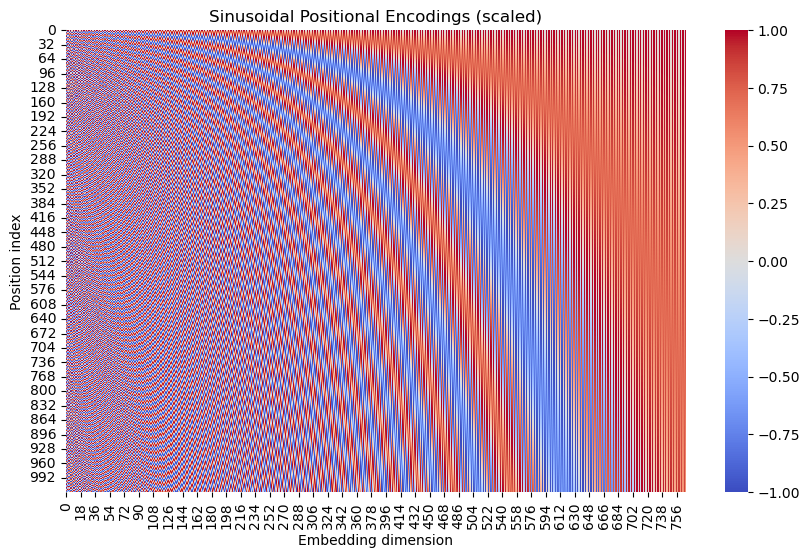

In [41]:
# In our usual notation: 
#   max_len = N
#   d_model = D
#   You can check what happens varying L --> just a rescaling

L = 1024

def sinusoidal_positional_encoding(max_len, d_model):
    pe = np.zeros((max_len, d_model)) # Initialize the PE matrix with all zeros
    position = np.arange(0, max_len)[:, np.newaxis] # Column vector of positions
    div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(L) / d_model)) # define the frequencies
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return pe

sinusoidal_encodings = sinusoidal_positional_encoding(L, 768)

plt.figure(figsize=(10, 6))
sns.heatmap(sinusoidal_encodings, cmap="coolwarm", center = 0)
plt.title("Sinusoidal Positional Encodings (scaled)")
plt.xlabel("Embedding dimension")
plt.ylabel("Position index")
plt.show()

# Positional Encoding Matrix visualization
In GPT-2 is not sinusoidal positional encoding to be used, but rather a learned-position embedding. Let's see what the NxD $\textbf{P}$ matrix looks like in this case. 

### Load GPT-2 base model (no LM head)

**Automodel** returns the base model without the language modeling head(no final prediction layer). 

Since **here we just want to extract internal embeddings or hidden representations (like positional encoding matrix and hidden states for each input token** - meaning that at each layer in the transformer, the model produces a vector representation for every token in the input sequence that can be thought of as contextualizeed embeddings: they represent each token _in context_, considering the other tokens around it. Basically it is the NxD $X_{seq}$ evolution), there's no need to generate score or text. It is a bit simpler and uses less memory.

_NOTICE:_
This is a generic factory class that automatically loads the right model class based on the checkpoint or config you provide. For example: 
```python
from transformers import AutoModel
model = AutoModel.from_pretrained("gpt2")
```
internally weill detect that "gpt2" corresponds to GPT2Model and return an instance of it. (Hence nothing changes from what presented in the Notebook 1_the_transformers_library.ipynb) except for the fact that here we're using (for no particular reason though) something more general taht would allow also to write code that works for different models (BERT, GPT-2, RoBERTa, etc.) without changing the class name.

In [42]:
# Load GPT-2 base model (no LM head)
model_name = "gpt2"
model = AutoModel.from_pretrained(model_name)

### Extract the learned positional embeddings

_NOTICE_: without these steps you might get an error like "RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead."

In [43]:
# model.wpe --> word position embedding layer inside GPT-2 (different from token embedding, which is the T x E matrix)
# .weight --> accesses the embedding matrix (N x D)
# .detach() --> removes the tensor from the PyTorch computational graph (no gradients needed, as we are not training)
# .cpu() --> moves the tensor to CPU memory (PyTorch tensors can live on GPU or CPU; NumPy cannot handle GPU tensors)
# .numpy() --> converts the tensor into a NumPy array for easier manipulation and visualization
positional_encodings = model.wpe.weight.detach().cpu().numpy()

# Print the shape of the positional encoding matrix
print(positional_encodings.shape)  # Should be (1024, 768)


(1024, 768)


Let's just double-check that Position index 0 corresponds to the first token in a sequence and so on...

In [45]:
from transformers import GPT2Tokenizer
import torch

# Load model + tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Example sentence (let's make it long enough)
sentence = "The quick brown fox jumps over the lazy dog. This is a test sentence to verify positional encodings inside GPT-2."

# Tokenize
tokens = tokenizer(sentence, return_tensors="pt")
input_ids = tokens['input_ids']  # (1, T) where T is the sequence length

# Get token and position embeddings manually
token_embeds = model.wte(input_ids)  # (1, T, D) 
pos_embeds = model.wpe.weight[:input_ids.shape[1], :].unsqueeze(0)  # (1, T, D) where batch dimension is added by unsqueeze

# Get actual embeddings passed into transformer
with torch.no_grad():
    outputs = model(input_ids, output_hidden_states=True, return_dict=True)
    hidden = outputs.hidden_states[0]  # (1, T, D)

# Compare for multiple positions
print(f"{'Pos':>4} | {'Pos emb norm':>12} | {'Diff norm':>10} | {'Diff - pos emb norm':>20}")
print("-" * 52)
for i in range(input_ids.shape[1]):
    t_i = token_embeds[0, i]
    p_i = pos_embeds[0, i]
    combined_i = hidden[0, i]

    diff = combined_i - t_i

    pos_norm = torch.norm(p_i).item()
    diff_norm = torch.norm(diff).item()
    delta = torch.norm(diff - p_i).item()

    print(f"{i:4d} | {pos_norm:12.6f} | {diff_norm:10.6f} | {delta:20.8f}")


 Pos | Pos emb norm |  Diff norm |  Diff - pos emb norm
----------------------------------------------------
   0 |     9.875602 |   9.875602 |           0.00000018
   1 |     5.192155 |   5.192155 |           0.00000014
   2 |     4.585272 |   4.585272 |           0.00000011
   3 |     4.336397 |   4.336397 |           0.00000017
   4 |     4.181058 |   4.181058 |           0.00000019
   5 |     4.060659 |   4.060659 |           0.00000008
   6 |     3.975894 |   3.975895 |           0.00000011
   7 |     3.908222 |   3.908222 |           0.00000014
   8 |     3.850706 |   3.850706 |           0.00000011
   9 |     3.807726 |   3.807726 |           0.00000010
  10 |     3.772757 |   3.772757 |           0.00000011
  11 |     3.736953 |   3.736953 |           0.00000010
  12 |     3.707106 |   3.707106 |           0.00000010
  13 |     3.671448 |   3.671448 |           0.00000014
  14 |     3.653787 |   3.653787 |           0.00000010
  15 |     3.633290 |   3.633290 |           0.0000

The difference between what is passed to the attention mechanism and the token embedding is basically exactly the positional encoding vector (ignoring numerical approximations), hence we can safely look and interpret the following graphs.

### Plot the positional encodings using a heatmap

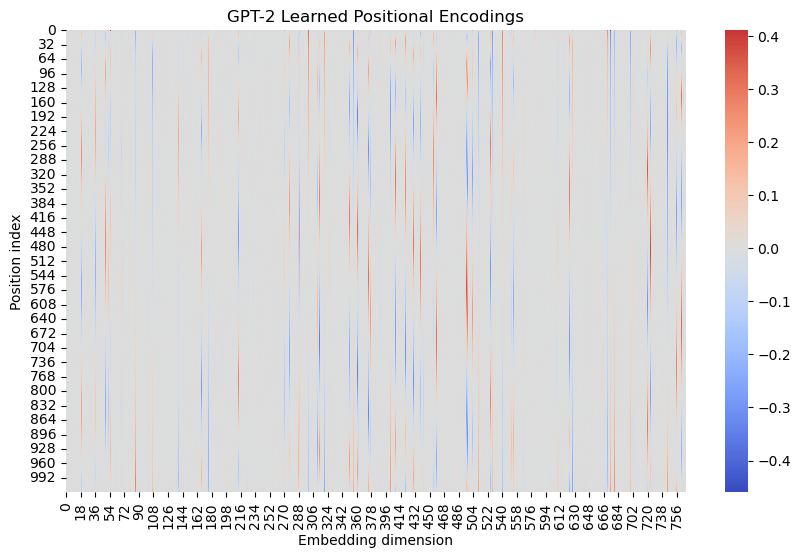

In [48]:
# Plotting normalized encodings only for better visualization
norm = np.linalg.norm(positional_encodings, axis=1).reshape(1024,1)
pos_normalized = positional_encodings / norm

plt.figure(figsize=(10, 6))
sns.heatmap(pos_normalized, cmap="coolwarm", center = 0)
plt.title("GPT-2 Learned Positional Encodings")
plt.xlabel("Embedding dimension")
plt.ylabel("Position index")
plt.show()

# Positional encoding trajectory

We can think of the embedding of a word as a vector anchored at the origin of our coordinate system. When we add the positional encoding to this embedding, it effectively shifts the vector’s tip along a trajectory that depends on the position within the sequence. As the position varies, this addition traces out a path in the embedding space. Studying this trajectory helps us understand how positional information is geometrically integrated into the token representation. 


### Norm of position vectors 
 


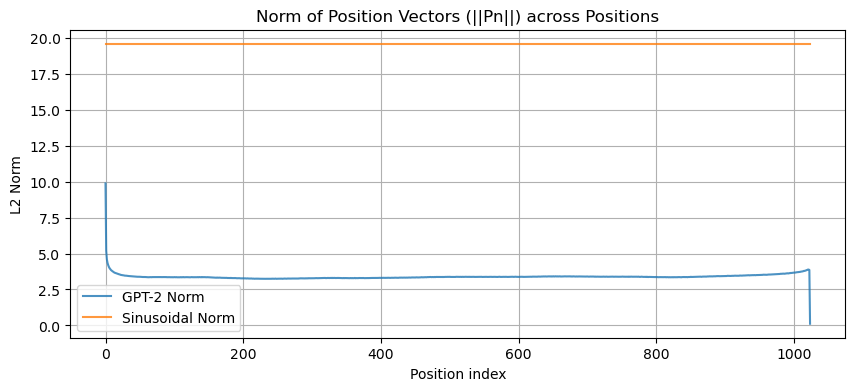

In [7]:
gpt2_norms = np.linalg.norm(positional_encodings, axis=1)
sine_norms = np.linalg.norm(sinusoidal_encodings, axis=1)

plt.figure(figsize=(10, 4))
plt.plot(gpt2_norms, label="GPT-2 Norm", alpha=0.8)
plt.plot(sine_norms, label="Sinusoidal Norm", alpha=0.8)
plt.title("Norm of Position Vectors (||Pn||) across Positions")
plt.xlabel("Position index")
plt.ylabel("L2 Norm")
plt.legend()
plt.grid(True)
plt.show()


**AS REGARDS SINUSOIDAL ENCODING:**

Sinusoidal encoding is expected to have a norm of $\sqrt(D/2)$ for each vector. 
Indeed when you're computing the norm of it you're summing pairwise $cos^2 + sin^2$ and then taking square root. 

In other words, by construction each $(\sin,\cos)$ pair at index $i$ satisfies

  $$
    \sin^2(a_i) + \cos^2(a_i) = 1,
  $$

  so for $d$-dimensional (even $d$) encodings,

  $$
    \|P_n\| = \sqrt{\,\tfrac d2\times 1\,}
            = \sqrt{\tfrac d2}.
  $$

  For $d=768$, that’s $\sqrt{384}\approx19.6$.


**AS REGARDS GPT-2 LEARNT ENCODING:**

First of all let's zoom a little in

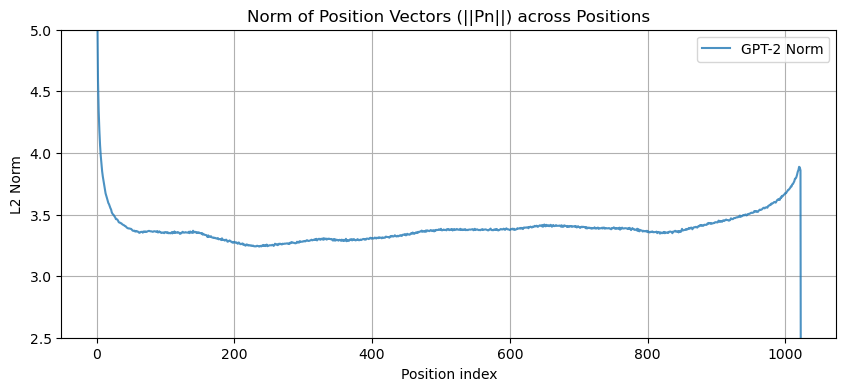

In [8]:
plt.figure(figsize=(10, 4))
plt.plot(gpt2_norms, label="GPT-2 Norm", alpha=0.8)
plt.title("Norm of Position Vectors (||Pn||) across Positions")
plt.xlabel("Position index")
plt.ylabel("L2 Norm")
plt.ylim(2.5,5)
plt.legend()
plt.grid(True)
plt.show()


# **_BOUNDARY BEHAVIOUR REMAINS A MISTERY_**

Of course, since weights are learnt, the values are not perfectly constant, but the variation is relatively small. 

**WHY CONSTANT?**

If some positional vectors had a much larger magnitude than others, the model would assign more *attention weight* to tokens at those positions.
This would unintentionally bias the model toward particular *positions* (e.g., early tokens, middle tokens, etc.).

Also, remember the model is trying to learn two things at once:

* The _content_ of the token (what word it is)
* The _position_ of the token (where it appears in the sequence)

If your positional encodings vary in _both_ magnitude and direction, the model has to disentangle:

* Was a token important because of its _position_ (and if so, was that due to *how large* the position vector was or *what direction* it pointed in)?
* Or because of its _content_?

Not having the magnitude bias lets attention layers focus on relative distances between tokens — which is essential for tasks like syntax, rhythm, and structure, where the *relative position* matters more than the *absolute index*.

Therefore, we'd like attention scores to depend not much (the least possible - see later note) on norms of input vectors, while we'd like it to depend on the angle between these vectors (remember that scalar product depends on the angle between vectors).

_NOTICE:_ equal PE norms guarantee only that $P_n$ itself does not bias attention by magnitude. However, of course, because each $P_n$ points in a different direction, of course norm of the sum token+position will still vary, unless you use a rotational scheme (like RoPE: only changes direction, never adds anything). 

$$
||a + b||^2 = ||a||^2 + ||b||^2 + 2a \cdot b
$$

BUT remember also that in high dimension almost all vectors are almost orthogonal, this is why you may see some fluctuations in norm but not much.

In [9]:
from transformers import GPT2Model

def sinusoidal_positional_encoding(max_pos, d_model, L=10000):
    pos = np.arange(max_pos)[:, np.newaxis]  # (max_pos, 1)
    i = np.arange(d_model)[np.newaxis, :]    # (1, d_model)
    
    exponent = (2 * (i // 2)) / d_model
    angle_rates = pos / np.power(L, exponent)

    pe = np.zeros((max_pos, d_model))
    pe[:, 0::2] = np.sin(angle_rates[:, 0::2])
    pe[:, 1::2] = np.cos(angle_rates[:, 1::2])

    return torch.tensor(pe, dtype=torch.float32)

# Load GPT-2 tokenizer + model to get token embeddings
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2")

# Pick a word and its token embedding
word = "dog"
token_id = tokenizer.encode(word, add_special_tokens=False)[0]

with torch.no_grad():
    token_embed = model.wte.weight[token_id]  # (D,)
    d_model = token_embed.shape[0]

# Generate sinusoidal positional encodings
max_pos = 10
#pos_encodings = sinusoidal_positional_encoding(max_pos, d_model)/4
pos_encodings = sinusoidal_positional_encoding(max_pos, d_model)

# Compute norms of combined embeddings
norms = []
for i in range(max_pos):
    combined = token_embed + pos_encodings[i]
    norms.append(torch.norm(combined).item())

# Print results
for i, n in enumerate(norms):
    print(f"Position {i:2d}: combined norm = {n:.6f}")

# Show that sinusoidal positional encodings have (approximately) constant norm
pos_norms = [torch.norm(pos_encodings[i]).item() for i in range(max_pos)]
print("\nSinusoidal positional encoding norms:")
for i, n in enumerate(pos_norms):
    print(f"Position {i:2d}: pos norm = {n:.6f}")

# Token embedding norm
print(f"\nToken '{word}' norm = {torch.norm(token_embed).item():.6f}")


Position  0: combined norm = 19.880789
Position  1: combined norm = 19.900379
Position  2: combined norm = 19.893299
Position  3: combined norm = 19.877735
Position  4: combined norm = 19.871077
Position  5: combined norm = 19.877626
Position  6: combined norm = 19.886847
Position  7: combined norm = 19.883305
Position  8: combined norm = 19.860275
Position  9: combined norm = 19.826694

Sinusoidal positional encoding norms:
Position  0: pos norm = 19.595919
Position  1: pos norm = 19.595921
Position  2: pos norm = 19.595919
Position  3: pos norm = 19.595919
Position  4: pos norm = 19.595921
Position  5: pos norm = 19.595921
Position  6: pos norm = 19.595921
Position  7: pos norm = 19.595921
Position  8: pos norm = 19.595919
Position  9: pos norm = 19.595919

Token 'dog' norm = 4.087791


The fact that stays more or less 19 in combined is due to the fact that 4 << 19 and you have to take sqrt(4^2 + 19^2). 
You can check this by rescaling PE by 4 for example.



**WHAT ABOUT THE VALUE OF THIS CONSTANT?**

The input vector to attention mechanism is: 

$$
\text{input}_n = \text{token\_embedding}(w_n) + \text{positional\_embedding}(n)
$$

hence magnitudes (norms) of both vectors are important, and again, if you don't want to give too much weight to position with respect to semantics, you may want to have token and positional embeddings to have comparable norms. 

At this regard, sinusoidal norms are high because they're untrained and fixed.
 GPT-2's norms are lower because the model learns a value that complements the scale of token embeddings without overpowering them.


In [10]:
# === Token embeddings ===
# Shape: (vocab_size, embedding_dim)
embedding_matrix = model.get_input_embeddings().weight.detach().cpu().numpy()

# Compute L2 norms of each token vector
token_norms = np.linalg.norm(embedding_matrix, axis=1)

# Statistics
mean_token_norm = np.mean(token_norms)
std_token_norm = np.std(token_norms)
max_token_norm = np.max(token_norms)
min_token_norm = np.min(token_norms)

print("Token Embedding Norms:")
print(f"  Average: {mean_token_norm:.4f}")
print(f"  Std dev: {std_token_norm:.4f}")
print(f"  Max:     {max_token_norm:.4f}")
print(f"  Min:     {min_token_norm:.4f}")

# === Positional encodings ===
# Shape: (max_position_embeddings, embedding_dim)
positional_matrix = model.wpe.weight.detach().cpu().numpy()

# Compute L2 norms of each positional vector
pos_norms = np.linalg.norm(positional_matrix, axis=1)

# Statistics
mean_pos_norm = np.mean(pos_norms)
std_pos_norm = np.std(pos_norms)
max_pos_norm = np.max(pos_norms)
min_pos_norm = np.min(pos_norms)

print("\nPositional Encoding Norms:")
print(f"  Average: {mean_pos_norm:.4f}")
print(f"  Std dev: {std_pos_norm:.4f}")
print(f"  Max:     {max_pos_norm:.4f}")
print(f"  Min:     {min_pos_norm:.4f}")


Token Embedding Norms:
  Average: 3.9585
  Std dev: 0.4337
  Max:     6.3155
  Min:     2.4537

Positional Encoding Norms:
  Average: 3.3901
  Std dev: 0.2620
  Max:     9.8756
  Min:     0.1179


### Angles between position vectors

As introduced before, since norms is not the main tool we'd like to use to "weight" the attention between tokens, we want to check what is instead the effect of angles, if there's any. This is what we'd like to rely on.

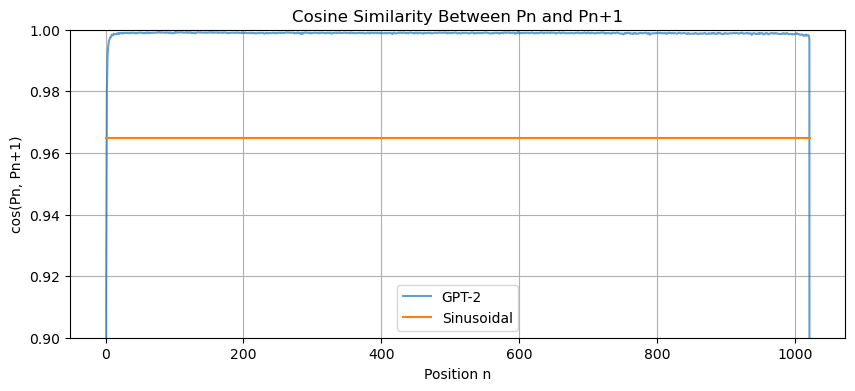

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

# Cosine similarity between each Pn and Pn+1
cos_sim = [
    cosine_similarity([positional_encodings[i]], [positional_encodings[i+1]])[0, 0] # [0,0] estracts the scalar similarity value from the resulting 1x1 matrix
    for i in range(len(positional_encodings) - 1)
]

cos_sim_sine = [
    cosine_similarity([sinusoidal_encodings[i]], [sinusoidal_encodings[i+1]])[0, 0]
    for i in range(len(sinusoidal_encodings) - 1)
]

plt.figure(figsize=(10, 4))
plt.plot(cos_sim, label="GPT-2", alpha=0.7)
plt.plot(cos_sim_sine, label="Sinusoidal")
#plt.xlim(0,25)
plt.ylim(0.9, 1)
plt.title("Cosine Similarity Between Pn and Pn+1")
plt.xlabel("Position n")
plt.ylabel("cos(Pn, Pn+1)")
plt.legend()
plt.grid(True)
plt.show()


# **_BOUNDARY BEHAVIOUR REMAINS A MISTERY_**

**AS REGARDS SINUSOIDAL ENCODING:**

We expect sinusoidal positional encodings to provide a *translation-invariant* notion of relative distance. Seeing a flat line confirms our implementation is correct.

Mathematically:

* Let $d$ be the embedding dimension (assumed even).
* We interleave sine and cosine coordinates in pairs indexed by $i = 0,1, \dots , \frac{d}{2}-1$.

For position $n$, define for each $i$:

$$
a_i \;=\;\frac{n}{L^{2i/d}},
\qquad
P_n[2i]   = \sin(a_i),
\qquad
P_n[2i+1] = \cos(a_i).
$$

1. Compute the phase increment

   $$
     \Delta_i
     = \frac{n+1}{L^{2i/d}} \;-\;\frac{n}{L^{2i/d}}
     = \frac{1}{L^{2i/d}}.
   $$
2. One sine–cosine pair contributes

   $$
     \sin(a_i)\,\sin(a_i+\Delta_i)
     \;+\;
     \cos(a_i)\,\cos(a_i+\Delta_i).
   $$
3. Apply the trigonometric identity

   $$
     \sin x\,\sin(x+\delta)
     +\cos x\,\cos(x+\delta)
     = \cos\bigl((x+\delta)-x\bigr)
     = \cos(\delta).
   $$
4. Summing over all $d/2$ pairs gives

   $$
     P_n \!\cdot\! P_{n+1}
     = \sum_{i=0}^{d/2-1}\cos(\Delta_i),
   $$

   which is **independent of** $n$.

Since every $P_n$ has the same norm $||P_n||$, the cosine similarity is

$$
\cos(P_n,P_{n+1})
= \frac{P_n\cdot P_{n+1}}{\|P_n\|\;\|P_{n+1}\|}
= \frac{1}{\|P_n\|^2}\sum_{i}\cos(\Delta_i),
$$

and if $|P_n|^2=d$ (or any constant), this is a fixed constant for *all* $n$.

* A **flat** $cos(P_n,P_{n+1})$ means our encoding treats *any* adjacent positions identically (sinusoidal encoding causes a rotation of the same angle from a position to the adjacent one)

* This translation invariance is exactly what lets attention layers reason in terms of *relative* distance, without “drift” as $n$ grows. Indeed it is the _difference_ between positions that matters more than the absolute position. We want the similarity between $P_n$ and $P_{n+k}$ hence to depend only on $k$, not on $n$. 

**AS REGARDS GPT-2 LEARNT ENCODING:**

Looks also constant and very close to 1, let's zoom in a little...

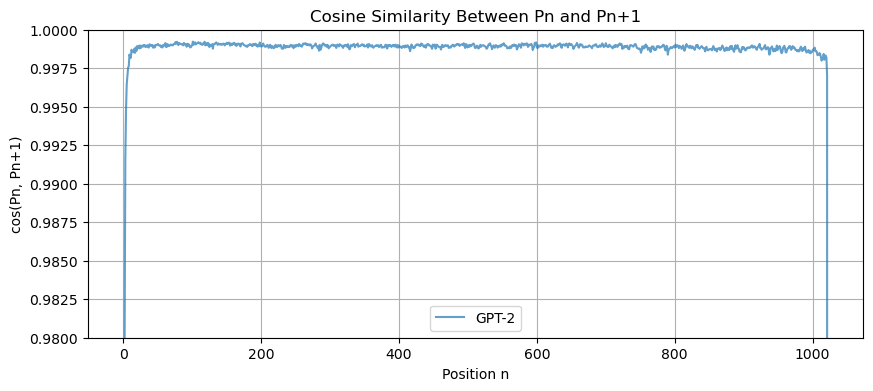

In [12]:
plt.figure(figsize=(10, 4))
plt.plot(cos_sim, label="GPT-2", alpha=0.7)
#plt.xlim(0,25)
plt.ylim(0.98, 1)
plt.title("Cosine Similarity Between Pn and Pn+1")
plt.xlabel("Position n")
plt.ylabel("cos(Pn, Pn+1)")
plt.legend()
plt.grid(True)
plt.show()


Cosine similarity is always close (BUT NOT EQUAL) to one... this means that adjacent vectors are ALMOST parallel.

Learned embeddings however are free to optimize. The model may have found that small directional changes suffice to encode position information for the attention mechanism... is it so? Let's have a look at the cumulative cosine similarity.



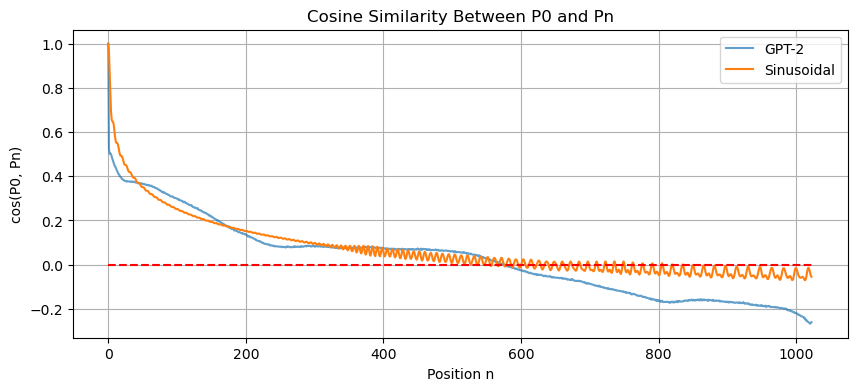

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

# Cosine similarity between each P0 and Pn
cos_sim = [
    cosine_similarity([positional_encodings[0]], [positional_encodings[i]])[0, 0] # [0,0] estracts the scalar similarity value from the resulting 1x1 matrix
    for i in range(len(positional_encodings) - 1)
]

cos_sim_sine = [
    cosine_similarity([sinusoidal_encodings[0]], [sinusoidal_encodings[i]])[0, 0]
    for i in range(len(sinusoidal_encodings) - 1)
]

plt.figure(figsize=(10, 4))
plt.plot(cos_sim, label="GPT-2", alpha=0.7)
plt.plot(cos_sim_sine, label="Sinusoidal")
plt.hlines(y = 0, xmin = 0, xmax = 1024, colors = 'red', linestyles= 'dashed')
plt.title("Cosine Similarity Between P0 and Pn")
plt.xlabel("Position n")
plt.ylabel("cos(P0, Pn)")
plt.legend()
plt.grid(True)
plt.show()

This shows that the positional encoding is NOT doing a rigid translation of the whole buffer by the same vector, which would be very strange and not in accord with the earlier heatmap.

This shows indeed that starting from very much aligned vectors, with the increase of distance in position of the two vectors, also the angle between them increases. 

Moreover, not only the vectors become orthogonal, but they even start to point in opposite directions. 

To globally visualize better this behavior we can look at the following heatmaps, which are consistent indeed with what we find in the above plot. 

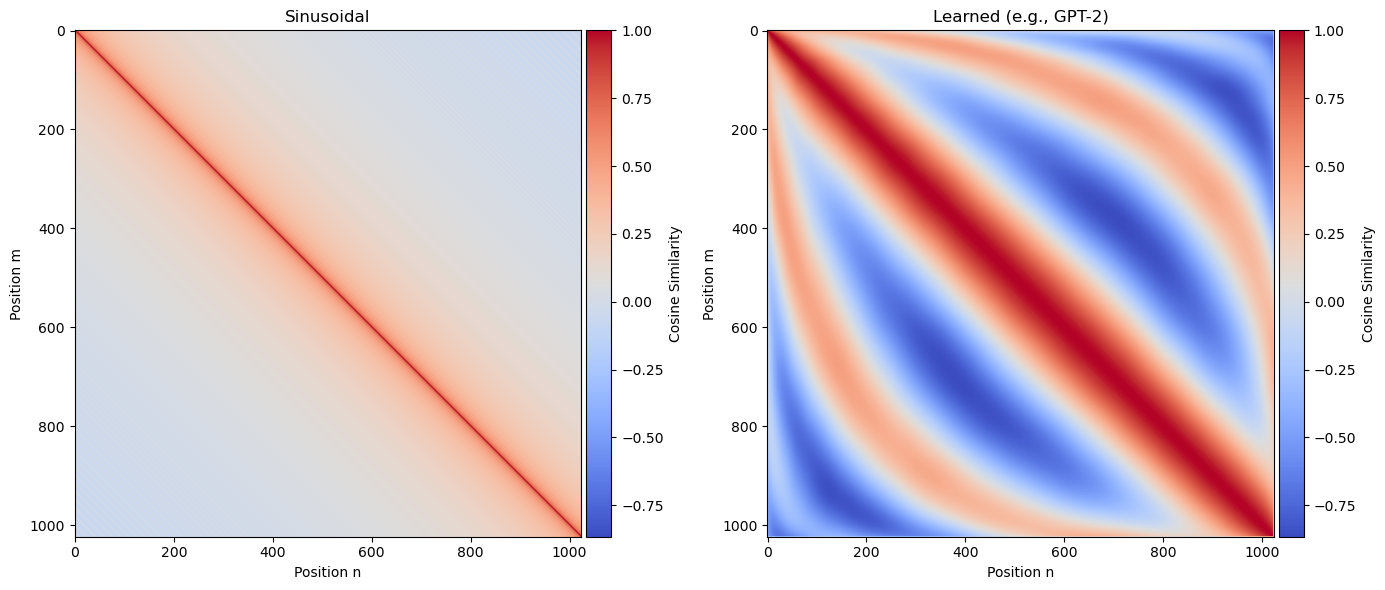

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Compute similarity matrices
sim_sin = cosine_similarity(sinusoidal_encodings)
sim_learned = cosine_similarity(positional_encodings)

# Compute global vmin, vmax
vmin = min(sim_sin.min(), sim_learned.min())
vmax = max(sim_sin.max(), sim_learned.max())

# Plot sinusoidal
im0 = axs[0].imshow(sim_sin, cmap='coolwarm', vmin=vmin, vmax=vmax)
axs[0].set_title("Sinusoidal")
axs[0].set_xlabel("Position n")
axs[0].set_ylabel("Position m")

# Plot learned
im1 = axs[1].imshow(sim_learned, cmap='coolwarm', vmin=vmin, vmax=vmax)
axs[1].set_title("Learned (e.g., GPT-2)")
axs[1].set_xlabel("Position n")
axs[1].set_ylabel("Position m")

# Use make_axes_locatable to avoid overlap
divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im0, cax=cax1, label="Cosine Similarity")
fig.colorbar(im1, cax=cax2, label="Cosine Similarity")

plt.tight_layout()
plt.show()


Indeed let's try cutting these plots at position (e.g.) 400 and see how the two encodings of some other position vectors behave with respect to that one. 

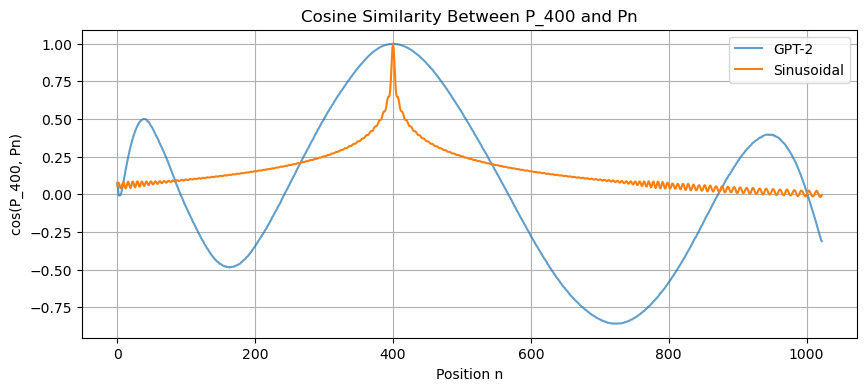

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

# Cosine similarity between each P_400 and Pn
cos_sim = [
    cosine_similarity([positional_encodings[400]], [positional_encodings[i]])[0, 0] # [0,0] estracts the scalar similarity value from the resulting 1x1 matrix
    for i in range(len(positional_encodings) - 1)
]

cos_sim_sine = [
    cosine_similarity([sinusoidal_encodings[400]], [sinusoidal_encodings[i]])[0, 0]
    for i in range(len(sinusoidal_encodings) - 1)
]

plt.figure(figsize=(10, 4))
plt.plot(cos_sim, label="GPT-2", alpha=0.7)
plt.plot(cos_sim_sine, label="Sinusoidal")
plt.title("Cosine Similarity Between P_400 and Pn")
plt.xlabel("Position n")
plt.ylabel("cos(P_400, Pn)")
plt.legend()
plt.grid(True)
plt.show()

# Can tokens overlap after positional encoding is added?

To check this we:

1. Get the token embeddings $T_i$ and positional encodings $P_i$
2. Compute pairwise distances: $||T_i - Tj||$ (distance between sphere centers)
3. Compute the pairwise sum of radii: $||P_i|| + ||P_j||$
4. Plot distribution of (sum of radii - distance) -> overlap if positive
5. Print % of overlapping pairs

### For GPT-2 Positional Encoding

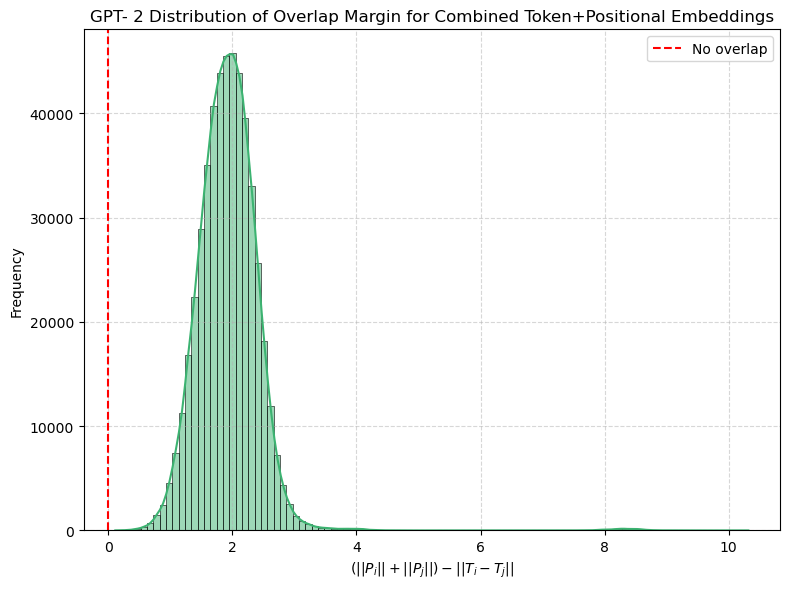

100.00% of token-position pairs overlap or touch as hyperspheres.


In [49]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt

# Get embeddings
embedding_matrix = model.get_input_embeddings().weight.detach().cpu().numpy()
positional_matrix = model.wpe.weight.detach().cpu().numpy()

# Max positions available
max_pos = positional_matrix.shape[0]

# Pick N tokens (N <= max_pos)
N_TOKENS = 1000
token_indices = np.random.choice(embedding_matrix.shape[0], N_TOKENS, replace=False)

# Combine with positional encodings for positions 0..N_TOKENS-1
T = embedding_matrix[token_indices, :]
P = positional_matrix[:N_TOKENS, :]

# Norms
T_norms = np.linalg.norm(T, axis=1)
P_norms = np.linalg.norm(P, axis=1)

# Pairwise distances
T_distances = squareform(pdist(T, metric='euclidean'))

# Pairwise radius sums
P_radii_sums = P_norms[:, None] + P_norms[None, :]

# Upper triangle (no diagonal)
i, j = np.triu_indices_from(T_distances, k=1)
dist_flat = T_distances[i, j]
radii_sum_flat = P_radii_sums[i, j]

# Difference
overlap_margin = radii_sum_flat - dist_flat

# Plot
plt.figure(figsize=(8, 6))
sns.histplot(overlap_margin, bins=100, kde=True, color="mediumseagreen", edgecolor="black")
plt.axvline(0, color='red', linestyle='--', label='No overlap')
plt.xlabel(r'$(||P_i|| + ||P_j||) - ||T_i - T_j||$')
plt.ylabel('Frequency')
plt.title('GPT- 2 Distribution of Overlap Margin for Combined Token+Positional Embeddings')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# % of pairs overlapping or touching
overlap_pct = (overlap_margin > 0).mean() * 100
print(f"{overlap_pct:.2f}% of token-position pairs overlap or touch as hyperspheres.")


Can we do this for ALL possible tokens?

No because for a GPT-2-like model with: 
- 50,257 tokens (V)
- 1024 positions (P)
    - you'd get over 51 million vectors
    - distance matrix would require $\sim$ 19.5 terabytes of RAM

So... not feasible, BUT we can repeat the experiment many times and look at the statistics of trials.

Trial 1/20: 100.00% overlapping, Mean overlap fraction: 0.00000
Trial 2/20: 100.00% overlapping, Mean overlap fraction: 0.00000
Trial 3/20: 100.00% overlapping, Mean overlap fraction: 0.00000
Trial 4/20: 100.00% overlapping, Mean overlap fraction: 0.00000
Trial 5/20: 100.00% overlapping, Mean overlap fraction: 0.00000
Trial 6/20: 100.00% overlapping, Mean overlap fraction: 0.00000
Trial 7/20: 100.00% overlapping, Mean overlap fraction: 0.00000
Trial 8/20: 100.00% overlapping, Mean overlap fraction: 0.00000
Trial 9/20: 100.00% overlapping, Mean overlap fraction: 0.00000
Trial 10/20: 100.00% overlapping, Mean overlap fraction: 0.00000
Trial 11/20: 100.00% overlapping, Mean overlap fraction: 0.00000
Trial 12/20: 100.00% overlapping, Mean overlap fraction: 0.00000
Trial 13/20: 100.00% overlapping, Mean overlap fraction: 0.00000
Trial 14/20: 100.00% overlapping, Mean overlap fraction: 0.00000
Trial 15/20: 100.00% overlapping, Mean overlap fraction: 0.00000
Trial 16/20: 100.00% overlapping, 

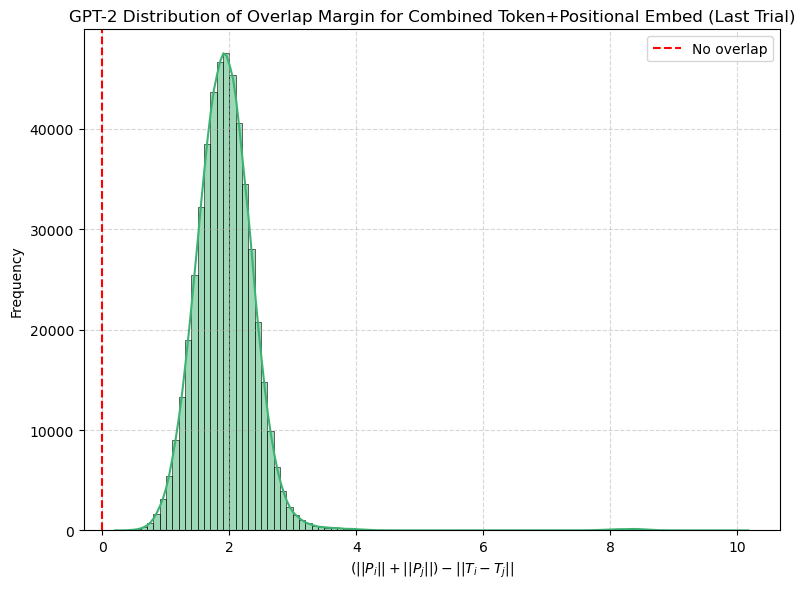

In [52]:
from scipy.spatial.distance import pdist, squareform
from scipy.special import betainc

# Get embeddings
embedding_matrix = model.get_input_embeddings().weight.detach().cpu().numpy()
positional_matrix = model.wpe.weight.detach().cpu().numpy()

# Parameters
N_TOKENS = 1000  # tokens per trial
N_TRIALS = 20    # number of trials
EMBED_DIM = embedding_matrix.shape[1]

overlap_pcts = []
mean_overlap_fractions = []

def intersection_fraction(n, d, r):
    """
    Computes fraction of overlap volume of two equal-radius hyperspheres.
    n: dimension
    d: distance between centers
    r: radius (assumed equal for both spheres)
    """
    if d >= 2 * r:
        return 0.0
    x = 1 - (d / (2 * r))**2
    return betainc((n + 1)/2, 0.5, x)

for trial in range(N_TRIALS):
    # Randomly pick N tokens
    token_indices = np.random.choice(embedding_matrix.shape[0], N_TOKENS, replace=False)
    
    # Positions 0..N_TOKENS-1
    P_indices = np.arange(N_TOKENS)
    
    # Extract embeddings and positions
    T = embedding_matrix[token_indices, :]
    P = positional_matrix[P_indices, :]
   
    # Norms
    T_norms = np.linalg.norm(T, axis=1)
    P_norms = np.linalg.norm(P, axis=1)
    
    # Pairwise distances
    T_distances = squareform(pdist(T, metric='euclidean'))
    
    # Pairwise radius sums
    P_radii_sums = P_norms[:, None] + P_norms[None, :]
    
    # Upper triangle indices
    i, j = np.triu_indices_from(T_distances, k=1)
    
    dist_flat = T_distances[i, j]
    radii_sum_flat = P_radii_sums[i, j]
    
    # Overlap margin
    overlap_margin = radii_sum_flat - dist_flat
    
    # % pairs overlapping
    overlap_pct = (overlap_margin > 0).mean() * 100
    overlap_pcts.append(overlap_pct)
    
    # Overlap volume fractions
    # Use mean radius for each pair
    r_pair = (P_norms[i] + P_norms[j]) / 2
    overlap_fractions = np.array([
        intersection_fraction(EMBED_DIM, d, r)
        for d, r in zip(dist_flat, r_pair)
    ])
    mean_overlap_fraction = overlap_fractions.mean()
    mean_overlap_fractions.append(mean_overlap_fraction)
    
    print(f"Trial {trial+1}/{N_TRIALS}: {overlap_pct:.2f}% overlapping, "
          f"Mean overlap fraction: {mean_overlap_fraction:.5f}")

# Summary statistics
overlap_pcts = np.array(overlap_pcts)
mean_overlap_fractions = np.array(mean_overlap_fractions)

mean_pct = overlap_pcts.mean()
std_pct = overlap_pcts.std()
p25, p75 = np.percentile(overlap_pcts, [25, 75])

mean_vol_frac = mean_overlap_fractions.mean()
std_vol_frac = mean_overlap_fractions.std()
vol_p25, vol_p75 = np.percentile(mean_overlap_fractions, [25, 75])

print("\nSummary over trials:")
print(f"Mean overlap %: {mean_pct:.2f}")
print(f"Std dev overlap %: {std_pct:.2f} \n")

print(f"Mean overlap volume fraction: {mean_vol_frac:.5f}")
print(f"Std dev overlap volume fraction: {std_vol_frac:.5f}")

# Optional: final plot of overlap margins from last trial
plt.figure(figsize=(8, 6))
sns.histplot(overlap_margin, bins=100, kde=True, color="mediumseagreen", edgecolor="black")
plt.axvline(0, color='red', linestyle='--', label='No overlap')
plt.xlabel(r'$(||P_i|| + ||P_j||) - ||T_i - T_j||$')
plt.ylabel('Frequency')
plt.title('GPT-2 Distribution of Overlap Margin for Combined Token+Positional Embed (Last Trial)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### For Sinusoidal Positional Encoding

Trial 1/20: 100.00% overlapping, Mean overlap fraction: 0.00096
Trial 2/20: 100.00% overlapping, Mean overlap fraction: 0.00096
Trial 3/20: 100.00% overlapping, Mean overlap fraction: 0.00096
Trial 4/20: 100.00% overlapping, Mean overlap fraction: 0.00096
Trial 5/20: 100.00% overlapping, Mean overlap fraction: 0.00096
Trial 6/20: 100.00% overlapping, Mean overlap fraction: 0.00096
Trial 7/20: 100.00% overlapping, Mean overlap fraction: 0.00096
Trial 8/20: 100.00% overlapping, Mean overlap fraction: 0.00096
Trial 9/20: 100.00% overlapping, Mean overlap fraction: 0.00096
Trial 10/20: 100.00% overlapping, Mean overlap fraction: 0.00096
Trial 11/20: 100.00% overlapping, Mean overlap fraction: 0.00096
Trial 12/20: 100.00% overlapping, Mean overlap fraction: 0.00096
Trial 13/20: 100.00% overlapping, Mean overlap fraction: 0.00096
Trial 14/20: 100.00% overlapping, Mean overlap fraction: 0.00096
Trial 15/20: 100.00% overlapping, Mean overlap fraction: 0.00096
Trial 16/20: 100.00% overlapping, 

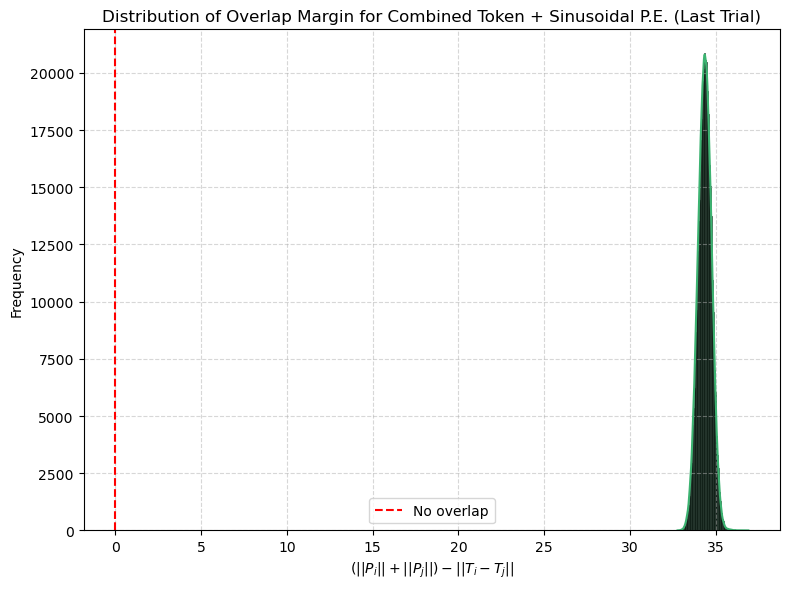

In [53]:
from scipy.spatial.distance import pdist, squareform
from scipy.special import betainc

# Get embeddings
embedding_matrix = model.get_input_embeddings().weight.detach().cpu().numpy()
positional_matrix = sinusoidal_encodings

# Parameters
N_TOKENS = 1000  # tokens per trial
N_TRIALS = 20    # number of trials
EMBED_DIM = embedding_matrix.shape[1]

overlap_pcts = []
mean_overlap_fractions = []

def intersection_fraction(n, d, r):
    """
    Computes fraction of overlap volume of two equal-radius hyperspheres.
    n: dimension
    d: distance between centers
    r: radius (assumed equal for both spheres)
    """
    if d >= 2 * r:
        return 0.0
    x = 1 - (d / (2 * r))**2
    return betainc((n + 1)/2, 0.5, x)

for trial in range(N_TRIALS):
    # Randomly pick N tokens
    token_indices = np.random.choice(embedding_matrix.shape[0], N_TOKENS, replace=False)
    
    # Positions 0..N_TOKENS-1
    P_indices = np.arange(N_TOKENS)
    
    # Extract embeddings and positions
    T = embedding_matrix[token_indices, :]
    P = positional_matrix[P_indices, :]
    
    # Norms
    T_norms = np.linalg.norm(T, axis=1)
    P_norms = np.linalg.norm(P, axis=1)
    
    # Pairwise distances
    V_distances = squareform(pdist(T, metric='euclidean'))
    
    # Pairwise radius sums
    P_radii_sums = P_norms[:, None] + P_norms[None, :]
    
    # Upper triangle indices
    i, j = np.triu_indices_from(T_distances, k=1)
    
    dist_flat = T_distances[i, j]
    radii_sum_flat = P_radii_sums[i, j]
    
    # Overlap margin
    overlap_margin = radii_sum_flat - dist_flat
    
    # % pairs overlapping
    overlap_pct = (overlap_margin > 0).mean() * 100
    overlap_pcts.append(overlap_pct)
    
    # Overlap volume fractions
    # Use mean radius for each pair
    r_pair = (P_norms[i] + P_norms[j]) / 2
    overlap_fractions = np.array([
        intersection_fraction(EMBED_DIM, d, r)
        for d, r in zip(dist_flat, r_pair)
    ])
    mean_overlap_fraction = overlap_fractions.mean()
    mean_overlap_fractions.append(mean_overlap_fraction)
    
    print(f"Trial {trial+1}/{N_TRIALS}: {overlap_pct:.2f}% overlapping, "
          f"Mean overlap fraction: {mean_overlap_fraction:.5f}")

# Summary statistics
overlap_pcts = np.array(overlap_pcts)
mean_overlap_fractions = np.array(mean_overlap_fractions)

mean_pct = overlap_pcts.mean()
std_pct = overlap_pcts.std()
p25, p75 = np.percentile(overlap_pcts, [25, 75])

mean_vol_frac = mean_overlap_fractions.mean()
std_vol_frac = mean_overlap_fractions.std()
vol_p25, vol_p75 = np.percentile(mean_overlap_fractions, [25, 75])

print("\nSummary over trials:")
print(f"Mean overlap %: {mean_pct:.2f}")
print(f"Std dev overlap %: {std_pct:.2f}")

print(f"Mean overlap volume fraction: {mean_vol_frac:.5f}")
print(f"Std dev overlap volume fraction: {std_vol_frac:.5f}")


# Optional: final plot of overlap margins from last trial
plt.figure(figsize=(8, 6))
sns.histplot(overlap_margin, bins=100, kde=True, color="mediumseagreen", edgecolor="black")
plt.axvline(0, color='red', linestyle='--', label='No overlap')
plt.xlabel(r'$(||P_i|| + ||P_j||) - ||T_i - T_j||$')
plt.ylabel('Frequency')
plt.title('Distribution of Overlap Margin for Combined Token + Sinusoidal P.E. (Last Trial)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


So, spheres DO overlap in GPT-2 encoding, and in the case of sinusoidal encoding they even MORE overlap BUT the probability of actually having two resulting vectors $V_i$ and $V_j$ pointing in the exact same point of space is very very low. 

**ABOUT OVERLAPPING VOLUME COMPUTATION:**

_NOTICE:_ In the above code we're using mean radius per pair for approximating equal-radius assumption.

Let's say we have two n-dimensional hyperspheres:

- Centered at points $T_i$ and $T_j$
- Radii $r_i$ and $r_j$

The _volume of their intersection_ depends on:

- The distance $d = || T_i - T_j ||$
- The radii $r_i$, $r_j$
- The dimension $n$

In general, for spheres with $r_i \neq r_j$, the intersection volume involves incomplete beta integrals or hypergeometric functions, or a multidimensional integral over the intersection region, There is no simple closed form.

When $r_i = r_j = r$, the volume overlap fraction is: 
$$
\text{Overlap fraction} = \frac{\text{Intersection volume}}{\text{Volume of one sphere}}
$$
and is given by:
$$
betainc(\frac{n+1}{2},\frac{1}{2}, 1 - (\frac{d}{2r})^2)
$$

This comes from integrating the cap volume of the hyperspheres.

The equal radii approximation is reasonable since our encodings as we've seen earlier are quite uniform in norm, especially in large dimension.

To be more precise we may use Monte Carlo methods: sample points in one sphere and check % inside the other, but not really necessary here.

**VOLUME CONCENTRATION IN HIGH DIMENSION**

1. _In very high dimension, the volume concentrates near the surface of the sphere._

<u> Proof: </u>

Consider the unit ball in $\mathbb{R}^d$:
$$
B_d = \{x \in \mathbb{R}^d: ||\bold{x} \leq 1||\}
$$

where $||\bold{x}||$ is the Euclidean norm.

The volume is: 
$$
V_d = \frac{\pi^{d/2}}{\Gamma(\frac{d}{2} + 1)}
$$

Suppose we consider the shell of the ball between radius $r = 1 - \epsilon$ and $r = 1$:
$$
S(\epsilon) = \{\bold{x} \in B_d: 1 - \epsilon \leq ||\bold{x}|| \leq 1 \}
$$

Since volume in d-dimensional space scales like $r^d$, the volume inside radius 1 - \epsioln is:

$$
V_{inner} = V_d (1 - \epsilon)^d
$$

Thus, the fraction of volume in the outer shell is: 
$$
\frac{V_{shell}}{V_d} = 1 - (1 - \epsilon)^d
$$

If $\epsilon << 1$:
$$
(1 - \epsilon)^d = e^{d ln (1- \epsilon)} \sim e^{-d \epsilon}
$$
so:
$$
\frac{V_{shell}}{V_d} \sim 1 - e^{-d \epsilon} \to 1 
$$
as $d \to \infty$. 

This means almost all the volume is in a very thin shell near the surface. 

2. _So what about the intersection of two spheres?_

Suppose you have two unit balls in $\mathbb{R}^d$, centere at distance $s \in (0,2)$ apart. The intersection volums is the volume of the lens-shaped region where they overlap. But _what is the overlap volume fraction?_

<u> Proof: </u>

We have two unit balls in $\mathbb{R}^d$:

$$
B_i = \{\mathbf{x} : \|\mathbf{x} - \mathbf{T}_i\| \le 1\}, 
\qquad
B_j = \{\mathbf{x} : \|\mathbf{x} - \mathbf{T}_j\| \le 1\},
$$

with center‐to‐center distance

$$
s = \|\mathbf{T}_i - \mathbf{T}_j\|,
\quad
0 \le s \le 2.
$$

We define the overlap fraction as:

$$
\text{Overlap fraction}
= \frac{\operatorname{vol}(B_i \cap B_j)}{\operatorname{vol}(B_i)},
\qquad
\operatorname{vol}(B_i) = V_d = \frac{\pi^{d/2}}{\Gamma\!\bigl(\tfrac{d}{2}+1\bigr)}.
$$

With radii $r_i = r_j = 1$, the intersection volume is twice a spherical‐cap volume:

$$
\operatorname{vol}(B_i\cap B_j) = 2\,V_{\rm cap}(h),
\qquad
h = 1 - \frac{s}{2}.
$$

The cap volume in $d$ dimensions is

$$
V_{\rm cap}(h) 
= \frac{1}{2}\,V_d\;I_{\,1 - (s/2)^2}\!\Bigl(\tfrac{d+1}{2},\,\tfrac12\Bigr),
$$

where the regularized incomplete beta is

$$
I_x(a,b)
= \frac{1}{B(a,b)}\int_0^x t^{a-1}\,(1-t)^{b-1}\,dt.
$$

Hence

$$
\frac{\operatorname{vol}(B_i\cap B_j)}{V_d}
= I_{\,1 - (s/2)^2}\!\Bigl(\tfrac{d+1}{2},\,\tfrac12\Bigr).
$$

As $d \to \infty$ the incomplete beta $I\_x(a,b)$ becomes sharply concentrated:

* If $s = o(1)$ then the overlap fraction $\to 1$.
* If $s = \Theta(1)$ then it decays exponentially in $d$.

In fact, for large \$d\$ one can approximate

$$
\frac{V_{\rm cap}(h)}{V_d}
\approx \exp\!\Bigl(-\tfrac{d\,s^2}{8}\Bigr),
$$

so

$$
\frac{\operatorname{vol}(B_i\cap B_j)}{V_d}
\approx 2\,\exp\!\Bigl(-\tfrac{d\,s^2}{8}\Bigr).
$$

Thus fixed‐separation spheres become essentially disjoint in high dimension.

In high dimension, almost all the volume of each sphere lies in a thin shell near the surface, and even small center‐to‐center separations $s=\Theta(1)$ yield exponentially small overlap.

# PCA

Each point in the 2D plot corresponds to one position (0 to 1023), represented in the reduced PCA space.

- Both learned (GPT-2) and sinusoidal matrices are size 1024 × 768: each row is a position vector, each column is an embedding dimension.

- PCA helps reduce high-dimensional vectors to 2D or 3D, so you can visualize trajectories or structures in position space.

- It allows us to compare how the position vectors evolve across n and see whether the learned embeddings form curved, linear, or more complex manifolds.

**How many dimensions retain 90% of variance?**


In [19]:
positional_encodings.shape

(1024, 768)

GPT-2 Learned Positional Encoding: 3 components retain 90% variance
Sinusoidal Positional Encoding: 153 components retain 90% variance


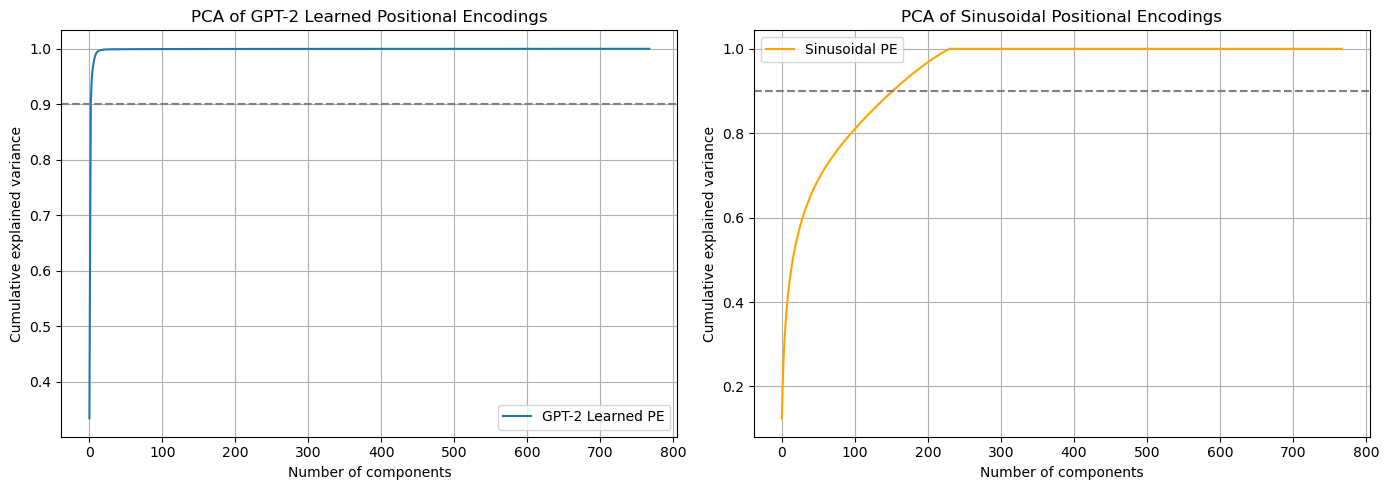

In [20]:
from sklearn.decomposition import PCA
import numpy as np

# PCA for GPT-2 learned positional encodings
pca_gpt2 = PCA() # create PCA objects (nsamples, nfeatures) = (1024, 768)
pca_gpt2.fit(positional_encodings) # compute the PC of normalized GPT-2 positional encodings 
cumsum_gpt2 = np.cumsum(pca_gpt2.explained_variance_ratio_) # cumulative sum of how much vairnace each component explains
n_components_gpt2 = np.searchsorted(cumsum_gpt2, 0.90) + 1 # find the index of the first component where cumulative variance reaches of exceeds 0.90 (plus one because of Python's zero-base)

# PCA for sinusoidal positional encodings
pca_sine = PCA()
pca_sine.fit(sinusoidal_encodings)
cumsum_sine = np.cumsum(pca_sine.explained_variance_ratio_)
n_components_sine = np.searchsorted(cumsum_sine, 0.90) + 1

print(f"GPT-2 Learned Positional Encoding: {n_components_gpt2} components retain 90% variance")
print(f"Sinusoidal Positional Encoding: {n_components_sine} components retain 90% variance")


fig, axs = plt.subplots(1, 2, figsize=(14, 5))
# Left: GPT-2 learned positional encoding cumulative spectrum
axs[0].plot(cumsum_gpt2, label="GPT-2 Learned PE")
axs[0].axhline(0.90, linestyle='--', color='gray')
axs[0].set_xlabel("Number of components")
axs[0].set_ylabel("Cumulative explained variance")
axs[0].set_title("PCA of GPT-2 Learned Positional Encodings")
axs[0].grid(True)
axs[0].legend()

# Right: sinusoidal positional encoding cumulative spectrum
axs[1].plot(cumsum_sine, label="Sinusoidal PE", color='orange')
axs[1].axhline(0.90, linestyle='--', color='gray')
axs[1].set_xlabel("Number of components")
axs[1].set_ylabel("Cumulative explained variance")
axs[1].set_title("PCA of Sinusoidal Positional Encodings")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

_NOTICE:_

Sklearn PCA uses by default as covariance matrix the feature's covariance matrix: 
$$
C = \frac{1}{n_{samples} - 1}X^TX
$$

This is because we want directions in feature space - eigenvectors of $X^TX$ give these directions. The dual (Gram) matrix $XX^T$ would give principal coordinates in sample space. 

The above computation is computationally efficient when: $D \leq N$. If we had the opposite then $XX^T$ ight be preferred. In that case you can compute eigenevectors of $XX^T$ and then project back to the eigenvectors of $X^TX$ using:

$$
v_i = \frac{1}{\lambda_i}X^Tu_i
$$

# **_ALRIGHT?_**

### Evolution of positional vectors as n increases (from 1 to N) along different dimensions

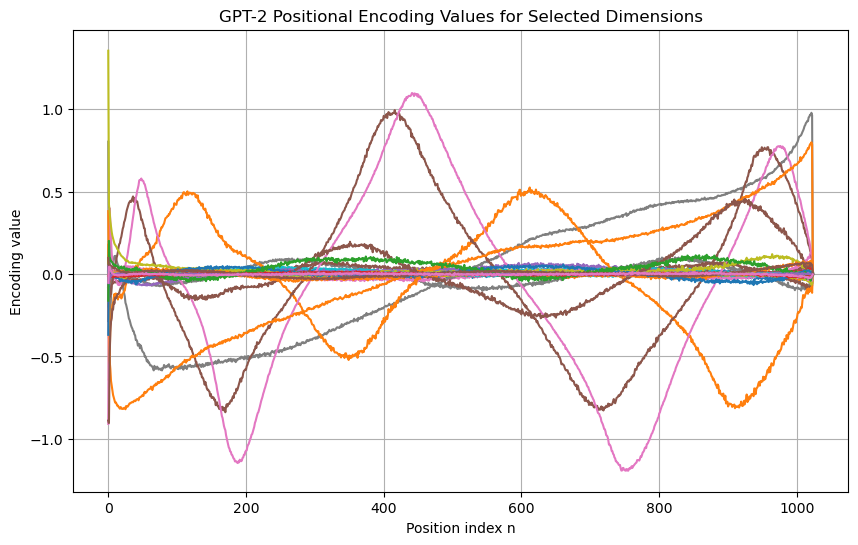

In [21]:
# dims_to_plot = [0, 1, 2, 3, 4]

plt.figure(figsize=(10, 6))
# for dim in dims_to_plot:
for dim in np.arange(1, 768,10):
    plt.plot(positional_encodings[:, dim], label=f"Dim {dim}")
plt.title("GPT-2 Positional Encoding Values for Selected Dimensions")
plt.xlabel("Position index n")
plt.ylabel("Encoding value")
#plt.legend()
plt.grid(True)
plt.show()


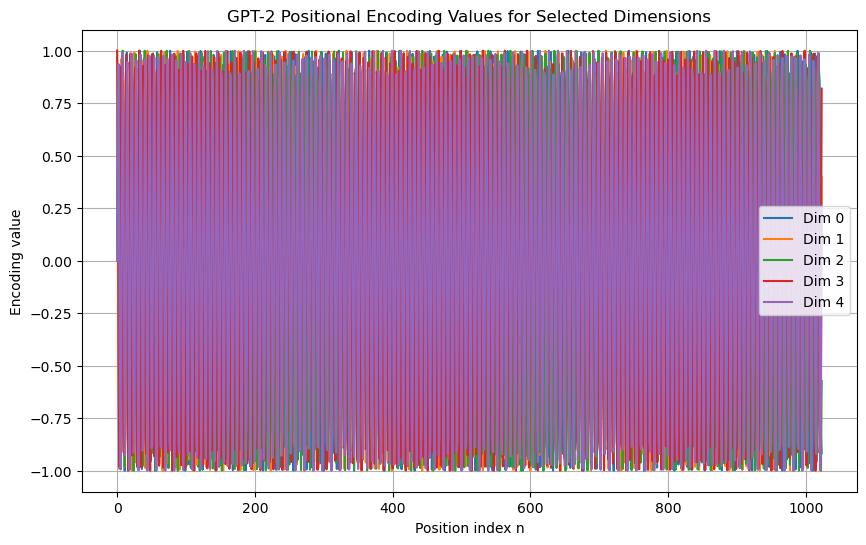

In [22]:
dims_to_plot = [0, 1, 2, 3, 4]

plt.figure(figsize=(10, 6))
for dim in dims_to_plot:
#for dim in np.arange(1, 768,10):
    plt.plot(sinusoidal_encodings[:, dim], label=f"Dim {dim}")
plt.title("GPT-2 Positional Encoding Values for Selected Dimensions")
plt.xlabel("Position index n")
plt.ylabel("Encoding value")
plt.legend()
plt.grid(True)
plt.show()


For a better comparison...

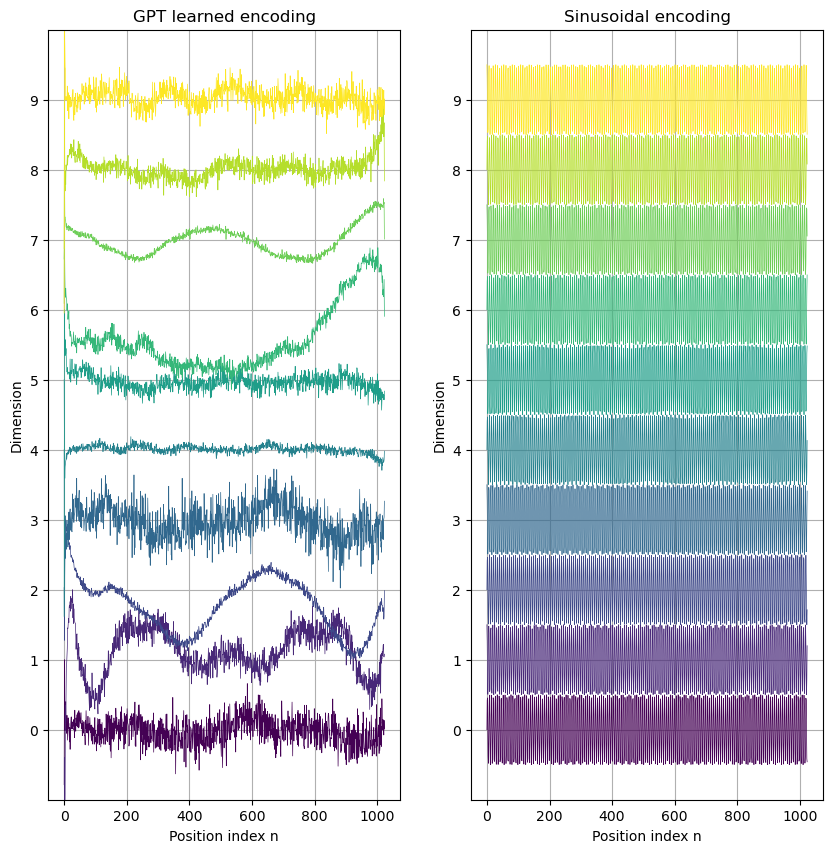

In [23]:
def plot_encoding(encoding, dims_to_plot, ax,title = "", scaling = 0.2, l = 0.5):
    cmap = plt.get_cmap('viridis', len(dims_to_plot)) 
    offset = 0.2
    for i, dim in enumerate(dims_to_plot):
        # Extract the positional encoding values for the current dimension dim across all positions (all rows in the encoding matrix)
        p = encoding[:, dim]
        # Normalize values p then multiply by scaling factor to control the amplitude on the plot
        p_scaled = p / np.max(p) * scaling
        # Plot with a vertical offset i*offset so each dimension is shifted upward on the y-axis to separate the lines visually
        ax.plot(p_scaled + i * offset, color = cmap(i), linewidth = l)

    ax.set_xlabel("Position index n")
    ax.set_ylabel("Dimension")
    yticks_positions = np.arange(0, len(dims_to_plot)) * offset
    ax.set_yticks(yticks_positions)
    ax.set_yticklabels(dims_to_plot)
    ax.set_ylim(-offset, len(dims_to_plot) * offset )
    ax.set_title(title)
    ax.grid()

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 10))
N = 10
plot_encoding(positional_encodings, dims_to_plot = np.arange(0, N), ax = axs[0], title = "GPT learned encoding")
plot_encoding(sinusoidal_encodings, dims_to_plot = np.arange(0, N), ax = axs[1], scaling = 0.1, title = "Sinusoidal encoding")
plt.show()

**Let's now look only at GPT-2 without any rescaling of amplitudes...**

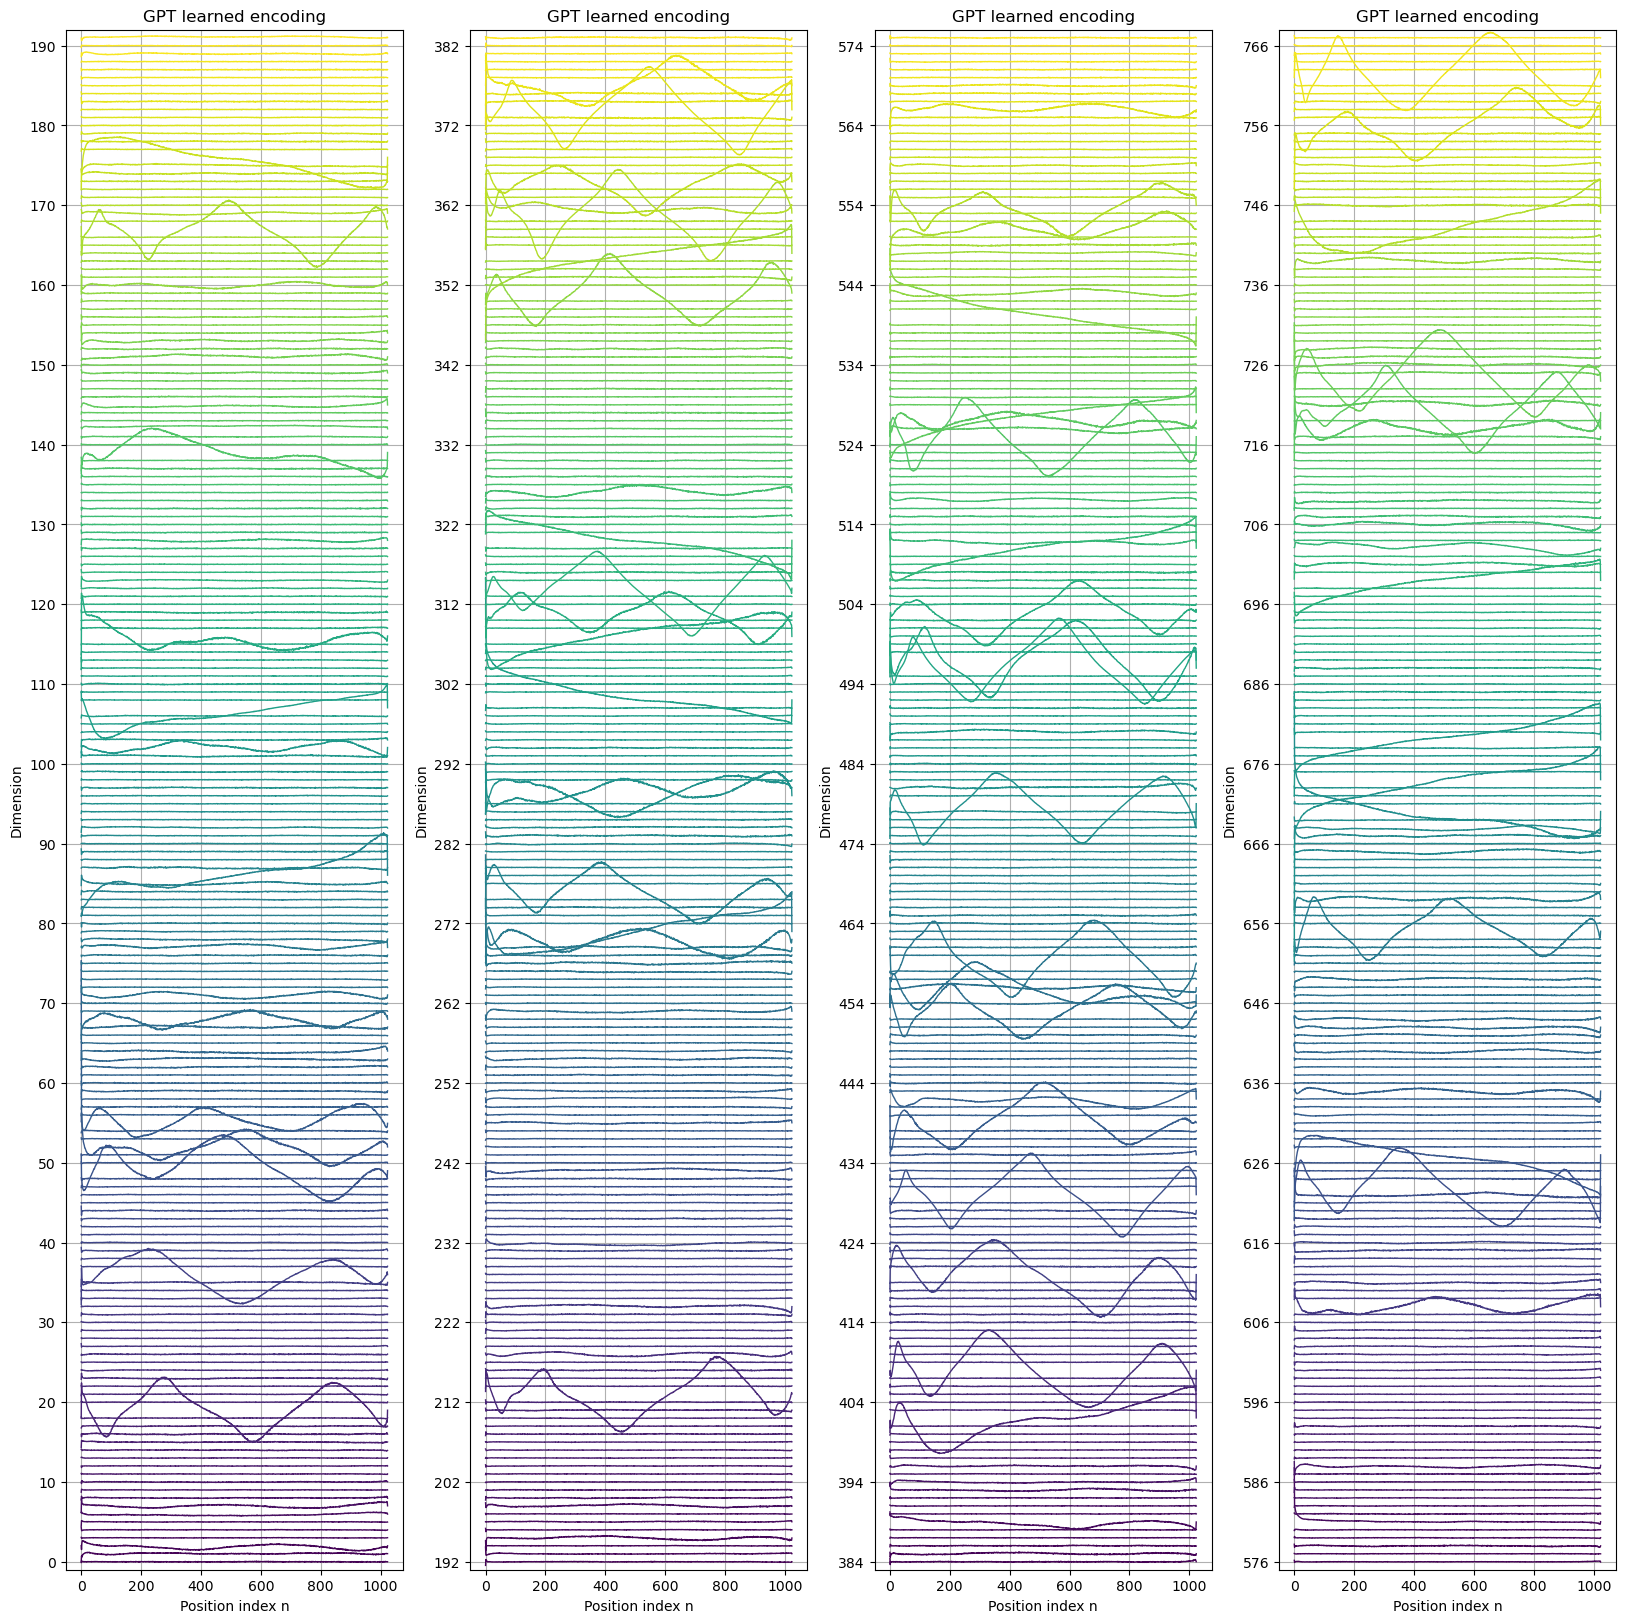

In [24]:
def plot_encoding_notscaled(encoding, dims_to_plot, ax,title = "", l = 1):
    cmap = plt.get_cmap('viridis', len(dims_to_plot)) 
    offset = 0.2
    for i, dim in enumerate(dims_to_plot):
        p = encoding[:, dim]
        ax.plot(p + i * offset, color = cmap(i), linewidth = l)

    ax.set_xlabel("Position index n")
    ax.set_ylabel("Dimension")
    yticks_positions = np.arange(0, len(dims_to_plot), 10) * offset
    ax.set_yticks(yticks_positions)
    ax.set_yticklabels(dims_to_plot[::10])
    ax.set_ylim(-offset, len(dims_to_plot) * offset )
    ax.set_title(title)
    ax.grid()


fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (20, 20))
dims_per_plot = 768//4
plot_encoding_notscaled(positional_encodings, dims_to_plot = np.arange(0, dims_per_plot), ax = axs[0], title = "GPT learned encoding")
plot_encoding_notscaled(positional_encodings, dims_to_plot = np.arange(dims_per_plot, 2*dims_per_plot), ax = axs[1], title = "GPT learned encoding")
plot_encoding_notscaled(positional_encodings, dims_to_plot = np.arange(2*dims_per_plot, 3*dims_per_plot), ax = axs[2], title = "GPT learned encoding")
plot_encoding_notscaled(positional_encodings, dims_to_plot = np.arange(3*dims_per_plot, 4*dims_per_plot), ax = axs[3], title = "GPT learned encoding")


**OBSERVATION:**

When I plot many positional encoding dimensions as a function of position index, I see that lots of them vary significantly across positions. But PCA tells me that only ~3 components explain 90% of the variance. How can both be true?

**Explaination:**

The fact that _many dimensions vary across position_ does not mean that their variations are _independent_. 

PCA is telling:

- The variations across position that you see in many dimensions are actually correlated in a specific way.

- The pattern of variation across all 768 dimensions at each position can be well-approximated by a combination of just 3 principal directions.

So while _many individual dimensions_ wiggle across positions, thos wiggles are not independent (as we can appreciate from the plot!) - they're just different linear combinations of the same few underlying modes (the principal components).



**What about sinusoidal encoding instead?**

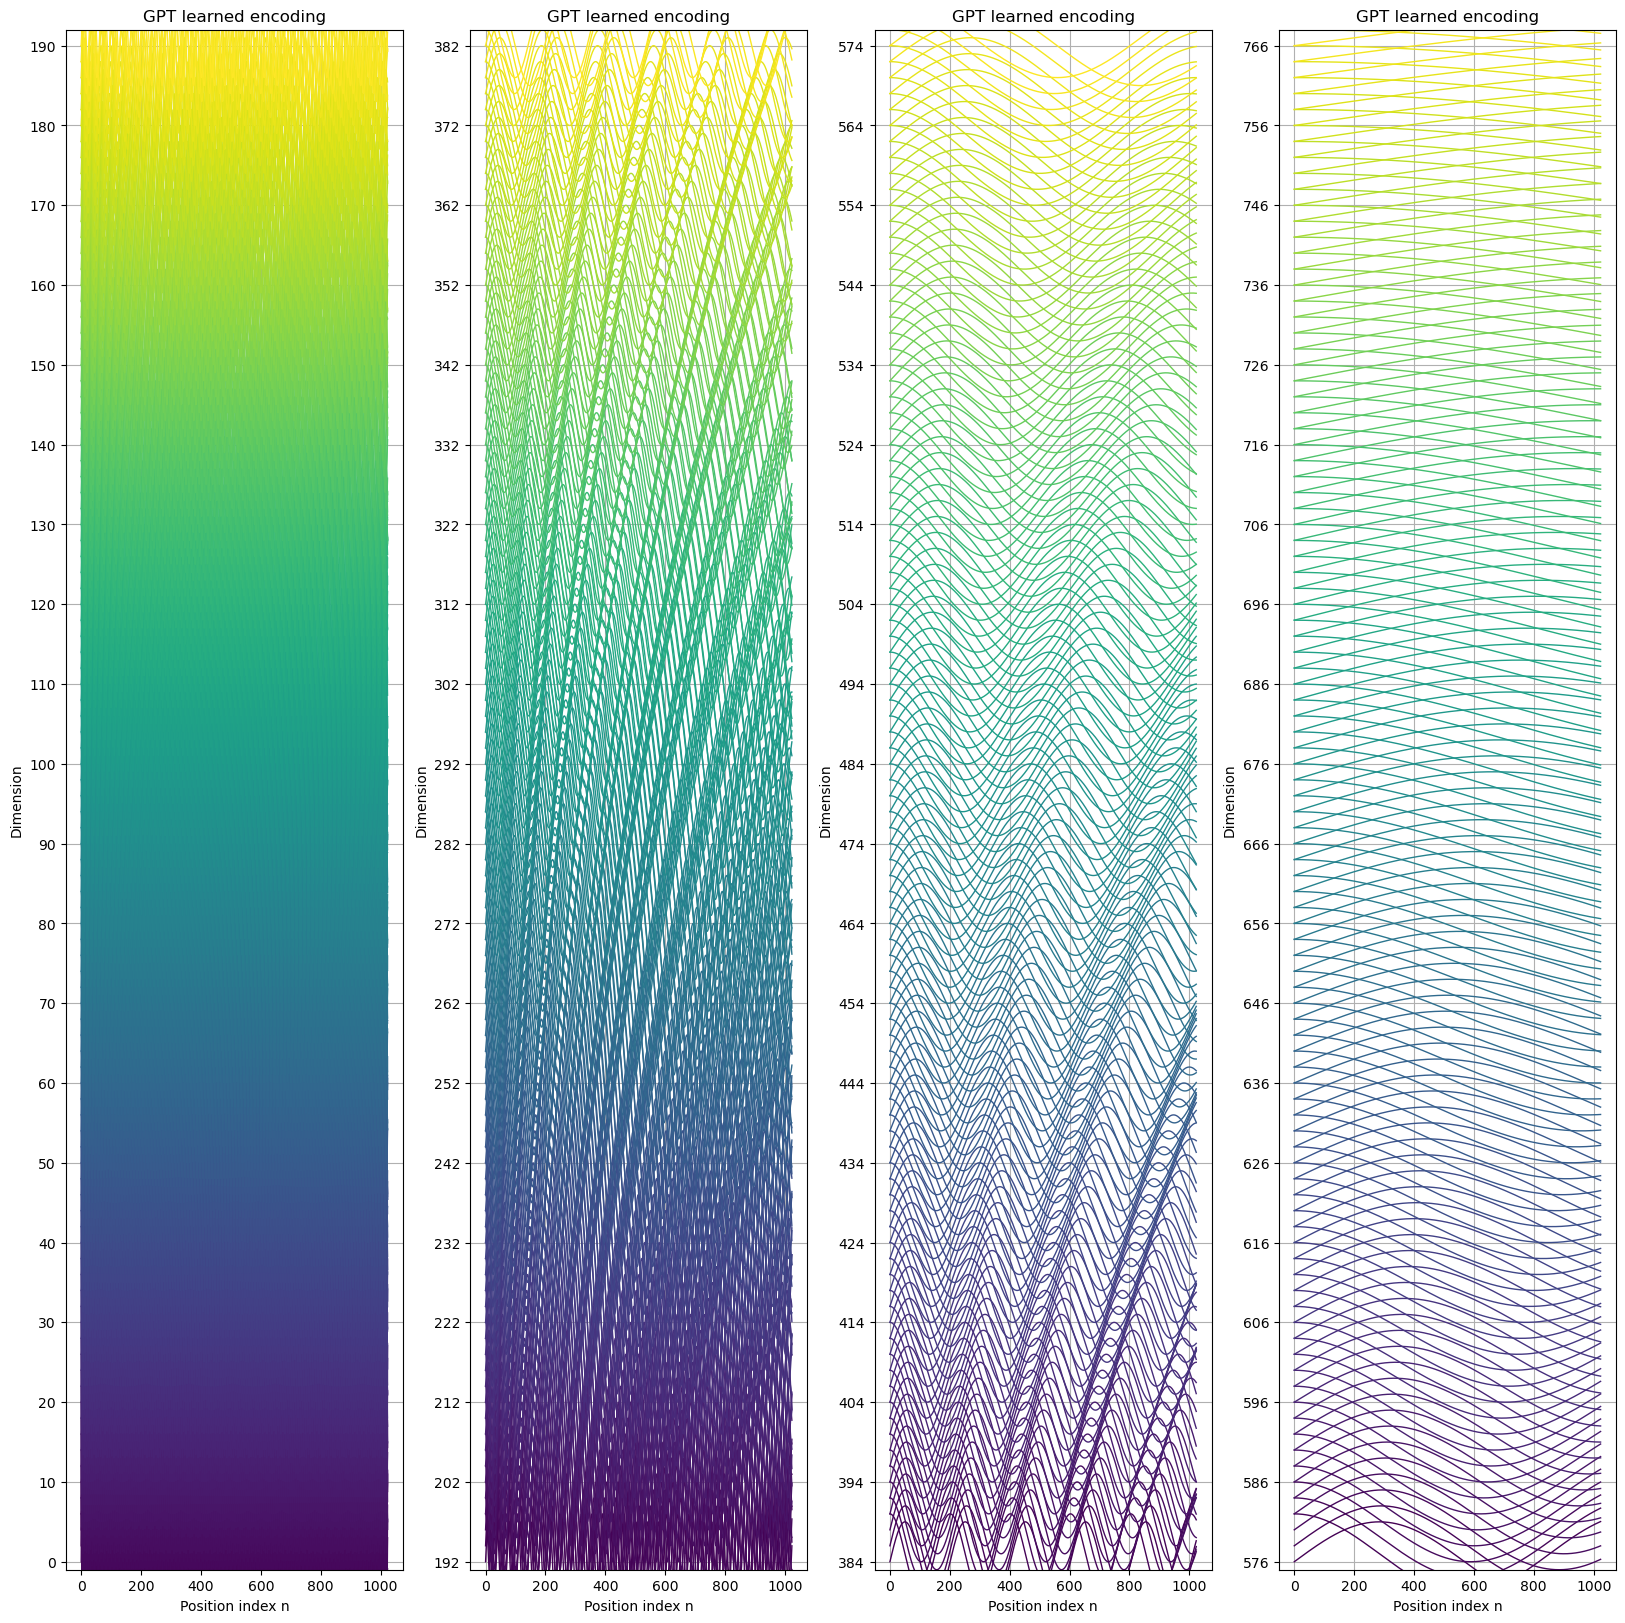

In [25]:
fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (20, 20))
dims_per_plot = 768//4
plot_encoding_notscaled(sinusoidal_encodings, dims_to_plot = np.arange(0, dims_per_plot), ax = axs[0], title = "GPT learned encoding")
plot_encoding_notscaled(sinusoidal_encodings, dims_to_plot = np.arange(dims_per_plot, 2*dims_per_plot), ax = axs[1], title = "GPT learned encoding")
plot_encoding_notscaled(sinusoidal_encodings, dims_to_plot = np.arange(2*dims_per_plot, 3*dims_per_plot), ax = axs[2], title = "GPT learned encoding")
plot_encoding_notscaled(sinusoidal_encodings, dims_to_plot = np.arange(3*dims_per_plot, 4*dims_per_plot), ax = axs[3], title = "GPT learned encoding")

**OBSERVATION:**

PCA can’t compress the matrix much: the variance is distributed across many principal components (because many different sinusoids are needed to reconstruct the full encoding matrix).

In the case of GPT-2 instead the model is free to choose _any_ pattern of variation across positions for each dimension, and it discovers a compact basis that suits its training task. 

### Test with Marchenko-Pastur law

The MP law tells you what spectrum you’d expect if these encodings were just random noise (no meaningful structure, no systematic positional info).

If the empirical eigenvalues significantly deviate from MP predictions (e.g., some large outliers above the MP bulk), that suggests non-random structure: → The positional encodings have directions of high variance = some positions are consistently mapped to certain latent directions → signal!

On the other hand:

If the spectrum matches MP perfectly, it could suggest that the encodings are not learning any low-dimensional structure (they're just noise-like).

Formally, our tast is: 

_Null hypothesis:_ "These positional encodings are equivalent to random noise (no structure)"

_Alternative hypothesis:_ "There are significant low-dimensional structure in the positional encodings - they encode position in a non-random way."

By comparing the actual spectrum of the positional encodings to the MP law, you can: 

- Detect low-rank signal -> are some directions used more than would happen by chance?
- Get insight into how many dimensions contribute meaningfully to encoding position.

_NOTICE:_
Learned positional encodings can still contain structured high-dimensional information that MP won't detect well if it doesn't express as large outlier eigenvalues. MP is mainly good for picking up strong low-dimensional signals or testing against pure noise.

For example:

If positional information is dispersed across many dimensions without large variance in any one direction → MP might not see strong deviations, but the encodings are still meaningful.

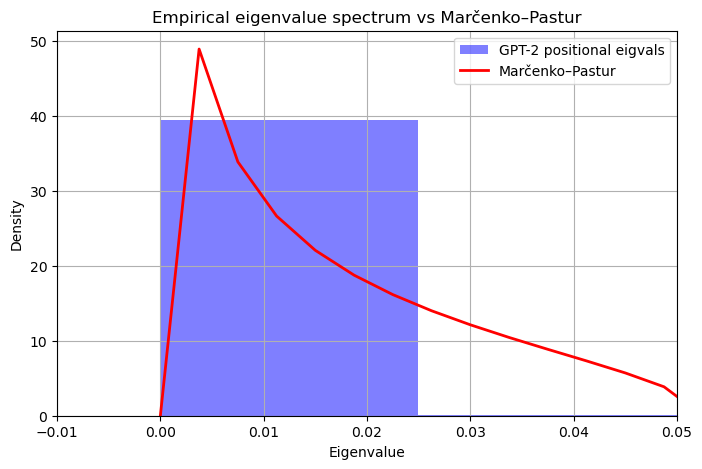

In [38]:
# Compute PCA
# pca_gpt2 = PCA()
# pca_gpt2.fit(positional_encodings)
# eigvals = pca_gpt2.explained_variance_  # eigenvalues of the covariance matrix

# 1) Center your data
X = positional_encodings
X_centered = X - X.mean(axis=0, keepdims=True)

# 2) Build the sample covariance matrix (1/n scaling)
n_samples = X_centered.shape[0]
cov = (X_centered.T @ X_centered) / n_samples

# 3) Compute its eigenvalues
eigvals, eigvecs = np.linalg.eigh(cov)      # eigh since cov is symmetric
eigvals = np.sort(eigvals)[::-1]            # sort descending

# Now `eigvals` are exactly the population of eigenvalues you’d plug into MP

# Parameters for MP law
n_samples, n_features = positional_encodings.shape
q = n_samples / n_features  # aspect ratio
sigma2 = np.var(positional_encodings)  # variance of data

# MP support
lambda_min = sigma2 * (1 - np.sqrt(1/q))**2
lambda_max = sigma2 * (1 + np.sqrt(1/q))**2

# Marcenko-Pastur density function
def mp_density(lambda_val, q, sigma2):
    lambda_min = sigma2 * (1 - np.sqrt(1/q))**2
    lambda_max = sigma2 * (1 + np.sqrt(1/q))**2
    density = np.zeros_like(lambda_val)
    mask = (lambda_val >= lambda_min) & (lambda_val <= lambda_max)
    density[mask] = (q / (2 * np.pi * sigma2 * lambda_val[mask])) * \
        np.sqrt((lambda_max - lambda_val[mask]) * (lambda_val[mask] - lambda_min))
    return density

# Plot
plt.figure(figsize=(8, 5))

# Histogram of empirical eigenvalues
plt.hist(eigvals, bins=150, density=True, alpha=0.5, color='blue', label='GPT-2 positional eigvals')

# MP density
lambda_vals = np.linspace(min(eigvals), max(eigvals), 1000)
mp_vals = mp_density(lambda_vals, q, sigma2)
plt.plot(lambda_vals, mp_vals, 'r-', lw=2, label='Marčenko–Pastur')

plt.xlabel('Eigenvalue')
plt.ylabel('Density')
plt.title('Empirical eigenvalue spectrum vs Marčenko–Pastur')
plt.xlim(-0.01,0.05)
plt.legend()
plt.grid(True)
plt.show()


# _**JUST NOISE-LIKE??**_